# Cluster DOMs by local ice properties

Use `get_doms_local_ice_properties.ipynb` to produce the files used by this for clustering.

## Notes and conclusions from the below work

The results of the bayesian gaussian clustering (80 clusters) were used for Spice Lea 5D tables (r, costheta, t, costhetadir, absdeltaphidir); tilt ON, anisotropy ON. Time was binned as residual time.

The results were better than using generic Spice Mie 5D tables (i.e., tilt off, no anisotropy in the Mie ice model) for timing but suffered in amplitude.

The theory for now is that we should try clustering only DeepCore sub-dust-layer DOMs (or only DOMs in that region but including both DC and IC) together to see if we get better amplitude information as well as the good timings we achieved.

For this effort, see `cluster_doms_by_localproperties_v2.ipynb`.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/justin/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [460]:
from collections import OrderedDict
from itertools import product
from os import *
from os.path import *
import sys
import time

import matplotlib.patheffects as path_effects
from scipy import stats, optimize

import hdbscan
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import seaborn as sns
from plotGoodies import removeBorder

from pisa.core.binning import OneDimBinning, MultiDimBinning
from pisa.core.map import Map, MapSet

sys.path.append(abspath('..'))
from retro.const import get_sd_idx, get_string_om_pair, NUM_DOMS_TOT
from retro.tables.clsim_tables import load_clsim_table_minimal
from retro.utils.geom import infer_power, powerspace

In [3]:
outdir = 'cluster_doms_by_local_properties'
if not isdir(outdir):
    makedirs(outdir)
outdir

'cluster_doms_by_local_properties'

In [4]:
plt.style.use('dark_background')

In [5]:
def plot_clusters(ax, zlabs, zequiv, al_sl, zunq_labs, zunq_cnt):
    n_colors = 1000
    palette = sns.color_palette(palette='rainbow', n_colors=n_colors)
    marker_colors = [palette[i] for i in (al_sl * n_colors).astype(int)]

    for string, dom in product(range(79, 87), range(1, 61)):
        sd_idx = get_sd_idx(string, dom)
        ax.plot(
            zlabs[sd_idx], zequiv[sd_idx],
            '_', ms=4, mew=0.1, mfc='none',
            mec=marker_colors[sd_idx], zorder=-1, alpha=1
        )

    ax.scatter(
        zlabs, zequiv,
        c=marker_colors, s=0.25, alpha=1
    )

    ymin, ymax = ax.get_ylim()
    for lab, cnt in zip(zunq_labs, zunq_cnt):
        ax.text(
            lab, ymax, format(cnt, 'd'),
            ha='center', va='top', fontsize=6, rotation=90
        )
        ax.text(
            lab, ymin, format(lab, 'd'),
            ha='center', va='bottom', fontsize=6, rotation=90
        )

    xmin, xmax = zunq_labs.min() - 0.5, zunq_labs.max() + 0.6
    removeBorder(ax, left=False, bottom=False)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(np.arange(xmin, xmax, 1), minor=True)
    ax.set_xticks([], minor=False)
    ax.grid(which='minor', b=True, lw=0.1, alpha=0.5)
    ax.grid(which='major', b=False)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('DOM z + tilt offset at DOM (m)')

In [6]:
def reorg_labels(labels, z):
    unq_labs, unq_inv, unq_cnt = np.unique(
        labels,
        return_inverse=True, return_counts=True
    )
    labs = unq_labs[unq_inv]

    zvals = np.full(shape=len(unq_labs), fill_value=np.nan)
    for orig_idx, lab in enumerate(unq_labs):
        # Handle "outlier" or "noise" labels, which are less than 0
        if lab < 0:
            zvals[orig_idx] = -np.inf
            continue
        mask = labs == lab
        zvals[orig_idx] = z[mask].max()
    zsort_indices = np.argsort(zvals)
    zunq_labs = np.empty_like(unq_labs)
    zunq_labs[zsort_indices] = unq_labs
    zlabs = zunq_labs[unq_inv]
    zunq_cnt = np.empty_like(unq_cnt)
    zunq_cnt[zsort_indices] = unq_cnt
    return zlabs, zunq_labs, zunq_cnt

In [8]:
#ppty_file = '../data/dom_clustering_properties_sphlocal.npy'
ppty_file = '../data/dom_clustering_properties_binned.npy'
#ppty_file = '../data/dom_clustering_properties_binned_opposite_sign_convention.npy'
properties = np.load(ppty_file)

x, y, z, zequiv = properties[:, 0], properties[:, 1], properties[:, 2], properties[:, 3]
hc0, hc1, hc2 = properties[:, 4], properties[:, 5], properties[:, 6]
abslen, scatlen = properties[:, 7], properties[:, 8]
n_sph_samps = properties.shape[1] - 9
sph_samps = properties[:, 9:]
abslen_sph_samps = sph_samps[:, :int(n_sph_samps//2)]
scatlen_sph_samps = sph_samps[:, int(n_sph_samps//2):]

abslen_min = abslen.min()
abslen_range = abslen.max() - abslen_min
scatlen_min = scatlen.min()
scatlen_range = scatlen.max() - scatlen_min
al_sl = 1/np.sqrt(2) * np.hypot((abslen - abslen_min) / abslen_range, (scatlen - scatlen_min) / scatlen_range)

properties.shape

(5160, 729)

In [9]:
if 'opposite' in ppty_file:
    sign_convention = '_opposite'
else:
    sign_convention = ''

Number of cluster labels (excluding "noise"): 20
Number of unclustered DOMs ("noise"):         52
CPU times: user 17.9 s, sys: 104 ms, total: 18 s
Wall time: 18.4 s


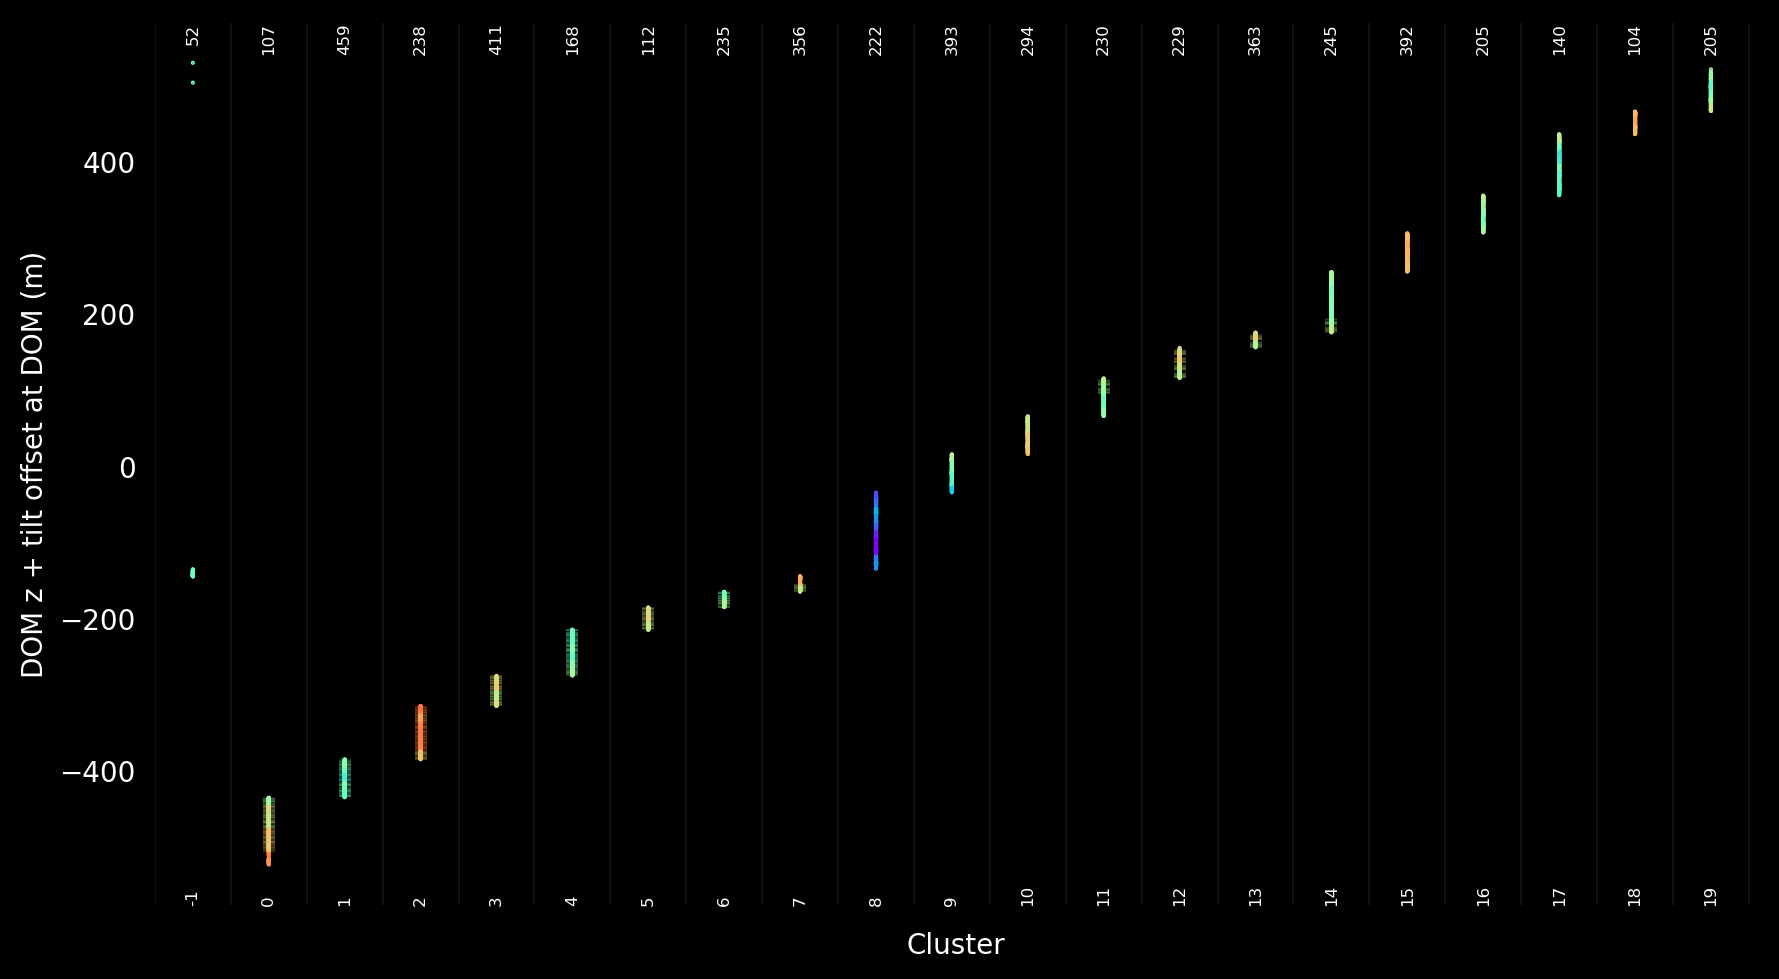

In [17]:
%%time

kw = dict(
    min_cluster_size=100,
    min_samples=10,
    cluster_selection_method='eom', # default = 'eom' (excess of mass); alternative = 'leaf'
    alpha=0.001 # default=1; larger -> more conservative
)

clusterer = hdbscan.HDBSCAN(**kw)
labels = clusterer.fit_predict(sph_samps)

zlabs, zunq_labs, zunq_cnt = reorg_labels(labels, z=zequiv)

print 'Number of cluster labels (excluding "noise"):', len(zunq_labs[zunq_labs != -1])
print 'Number of unclustered DOMs ("noise"):        ', np.sum(labels == -1)

fig, ax = plt.subplots(figsize=(9, 5), dpi=200)
plot_clusters(ax, zlabs, zequiv, al_sl, zunq_labs, zunq_cnt)
fig.tight_layout()

outfbase = join(
    outdir,
    'hdbscan_mcs{min_cluster_size}_ms{min_samples}_{cluster_selection_method}_alpha{alpha}'.format(**kw)
    + sign_convention
)

clustermap = save_clustermap(outfbase + '.npy', zlabs)

fig.savefig(outfbase + '.pdf')
fig.savefig(outfbase + '.png', dpi=300)
pass

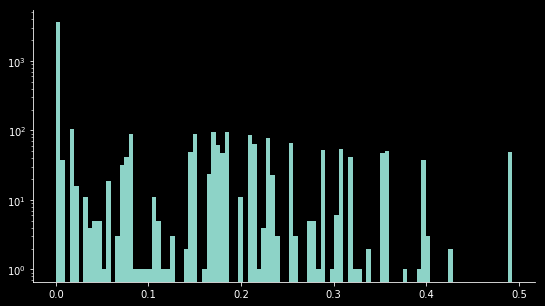

In [18]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=72)
plt.hist(clusterer.outlier_scores_, bins=100)
removeBorder(ax)
ax.grid(which='both', b=False)
ax.set_yscale('log')
pass

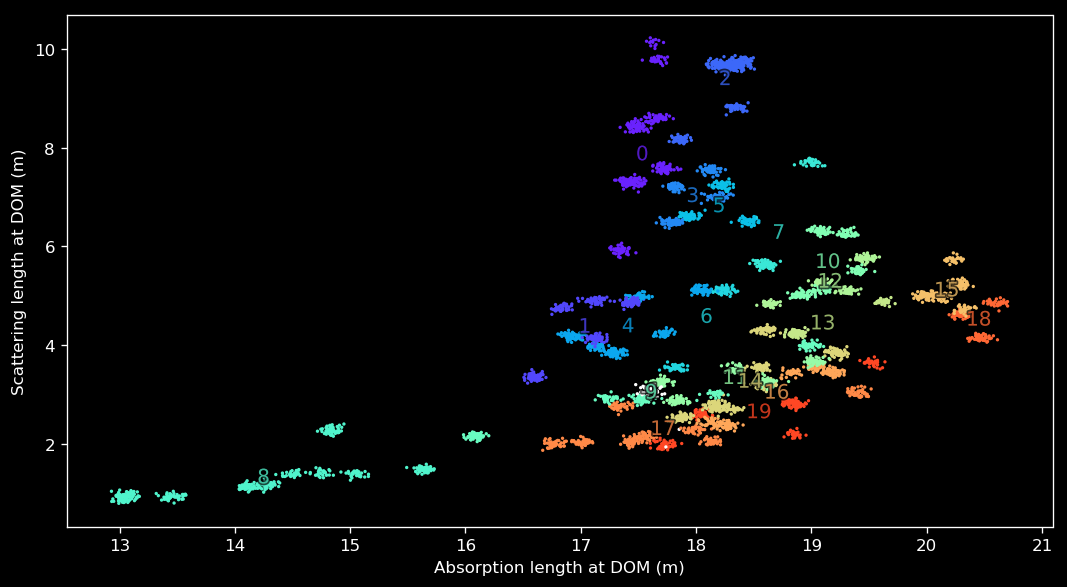

In [19]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
palette = sns.color_palette(
    #palette='tab20',
    palette='rainbow',
    n_colors=len(zunq_labs)
)
cluster_colors = [
    sns.desaturate(palette[col], 1) 
    if col >= 0 else (1,)*3
    for col, sat in zip(zlabs, clusterer.probabilities_)
]
rf = 0.05
ax.scatter(
    abslen + rf*np.random.randn(5160),
    scatlen + rf*np.random.randn(5160),
    c=cluster_colors, s=1, alpha=1
)

for lab in zunq_labs:
    mask = zlabs == lab
    abslen_med = np.median(abslen[mask])
    scatlen_med = np.median(scatlen[mask])
    abslen_mean = np.mean(abslen[mask])
    scatlen_mean = np.mean(scatlen[mask])
    #abslen_center, scatlen_center = clusterer.cluster_centers_[lab]
    txt = ax.text(
        abslen_mean, scatlen_mean,
        format(lab, 'd'),
        va='center', ha='center',
        fontsize=12,
        #color='w',
        color=palette[lab] if lab >= 0 else 'w',
        alpha=0.7
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

ax.grid(which='both', b=False)
ax.set_xlabel('Absorption length at DOM (m)')
ax.set_ylabel('Scattering length at DOM (m)')
fig.tight_layout()
pass

Number of cluster labels (excluding "noise"): 80
Number of DOMs classified as "noise":         0
CPU times: user 17.7 s, sys: 144 ms, total: 17.8 s
Wall time: 18 s


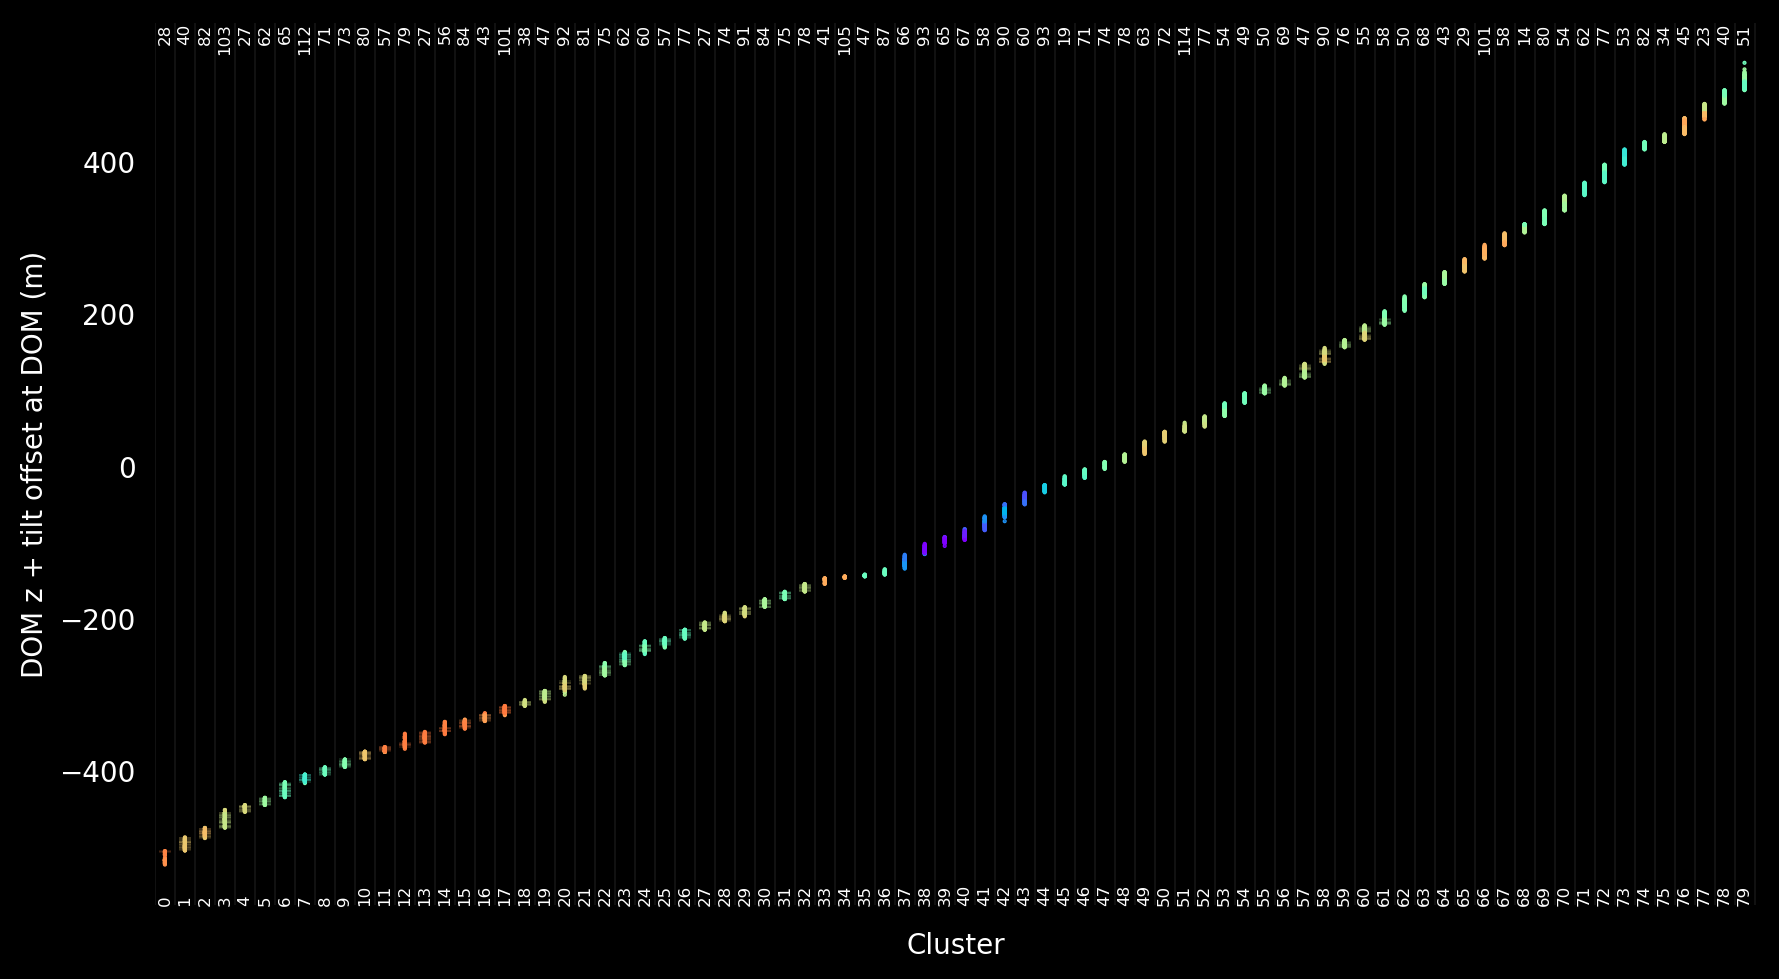

In [14]:
%%time

n_clusters = 80

clusterer = KMeans(n_clusters=n_clusters)
clusterer.fit(sph_samps)
labels = clusterer.fit_predict(sph_samps)

zlabs, zunq_labs, zunq_cnt = reorg_labels(labels, z=zequiv)

print 'Number of cluster labels (excluding "noise"):', np.sum(zunq_labs != -1)
print 'Number of DOMs classified as "noise":        ', np.sum(zlabs == -1)

fig, ax = plt.subplots(figsize=(9, 5), dpi=200)
plot_clusters(ax, zlabs, zequiv, al_sl, zunq_labs, zunq_cnt)
fig.tight_layout()

outfbase = join(outdir, 'kmeans_{:d}'.format(n_clusters) + sign_convention)

clustermap = save_clustermap(outfbase + '.npy', zlabs)

fig.savefig(outfbase + '.pdf')
fig.savefig(outfbase + '.png', dpi=300)
pass

Number of cluster labels (excluding "noise"): 80
Number of DOMs classified as "noise":         0
CPU times: user 1min 28s, sys: 1.81 s, total: 1min 30s
Wall time: 1min 30s


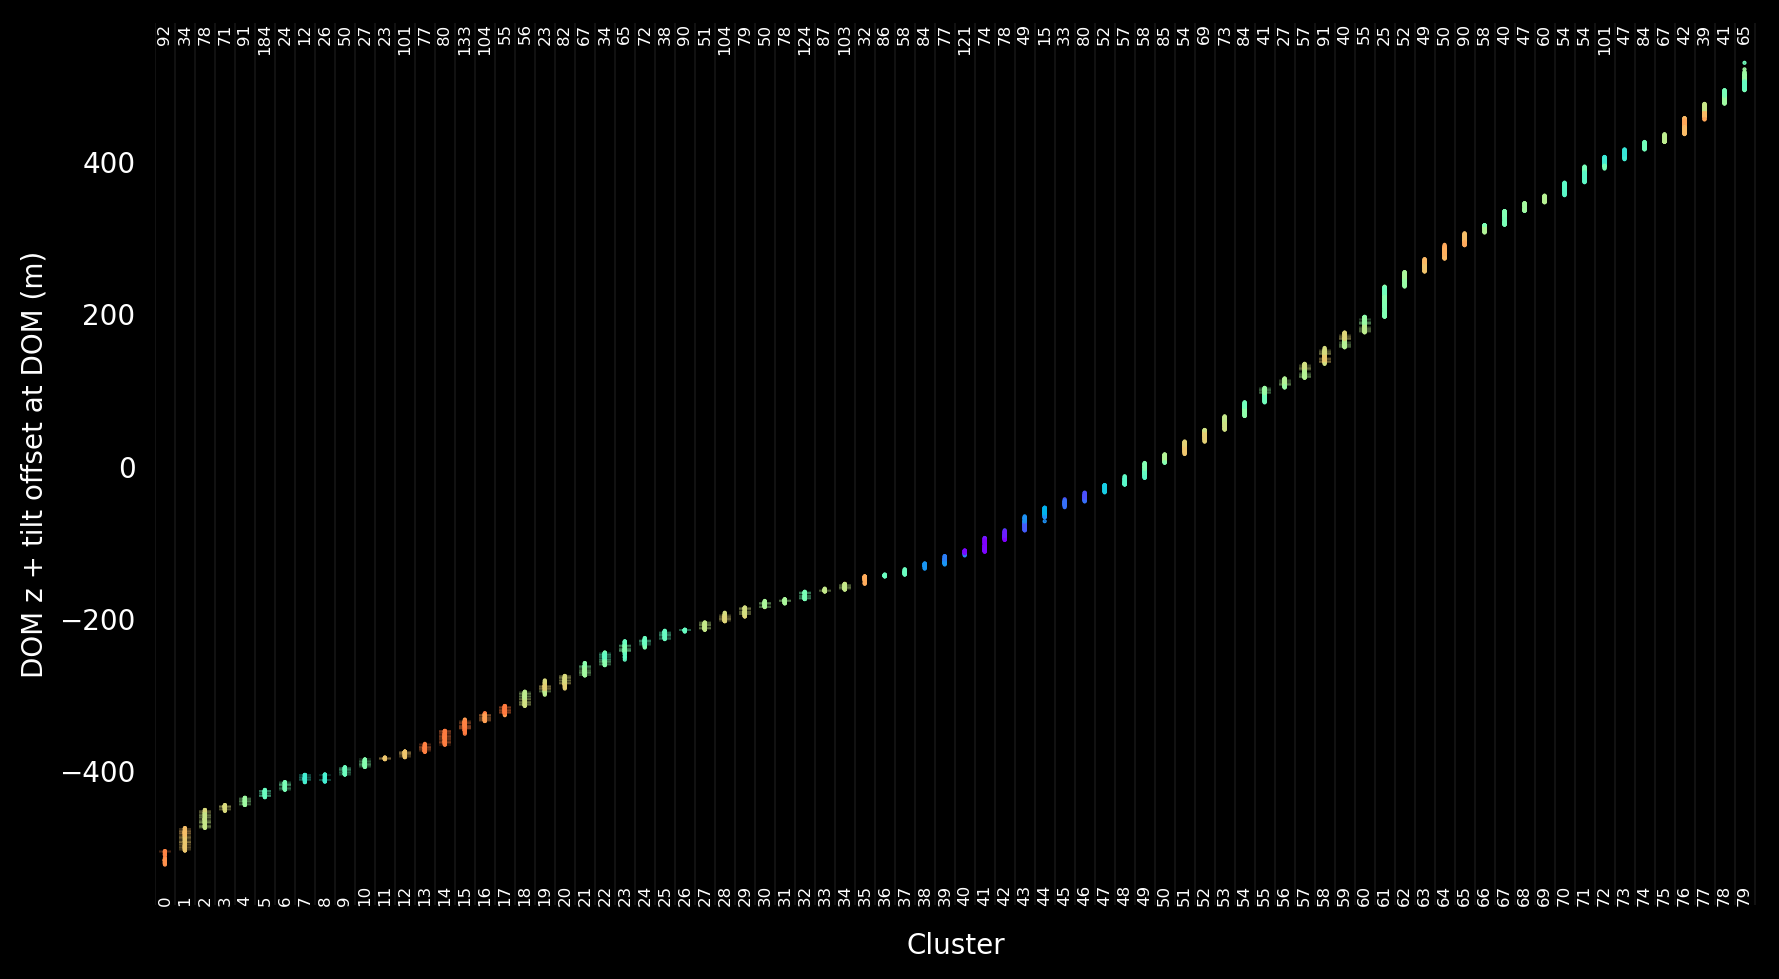

In [15]:
%%time

n_components = 80
clusterer = GaussianMixture(n_components=n_components)
clusterer.fit(sph_samps)

labels = clusterer.predict(sph_samps)

zlabs, zunq_labs, zunq_cnt = reorg_labels(labels, z=zequiv)

print 'Number of cluster labels (excluding "noise"):', np.sum(zunq_labs != -1)
print 'Number of DOMs classified as "noise":        ', np.sum(zlabs == -1)

fig, ax = plt.subplots(figsize=(9, 5), dpi=200)
plot_clusters(ax, zlabs, zequiv, al_sl, zunq_labs, zunq_cnt)
fig.tight_layout()

outfbase = join(outdir, 'gaussian_mixture_{:d}'.format(n_components) + sign_convention)

clustermap = save_clustermap(outfbase + '.npy', zlabs)

fig.savefig(outfbase + '.pdf')
fig.savefig(outfbase + '.png', dpi=300)
pass

Number of cluster labels (excluding "noise"): 80
Number of DOMs classified as "noise":         0
CPU times: user 1min 28s, sys: 2.32 s, total: 1min 30s
Wall time: 1min 30s


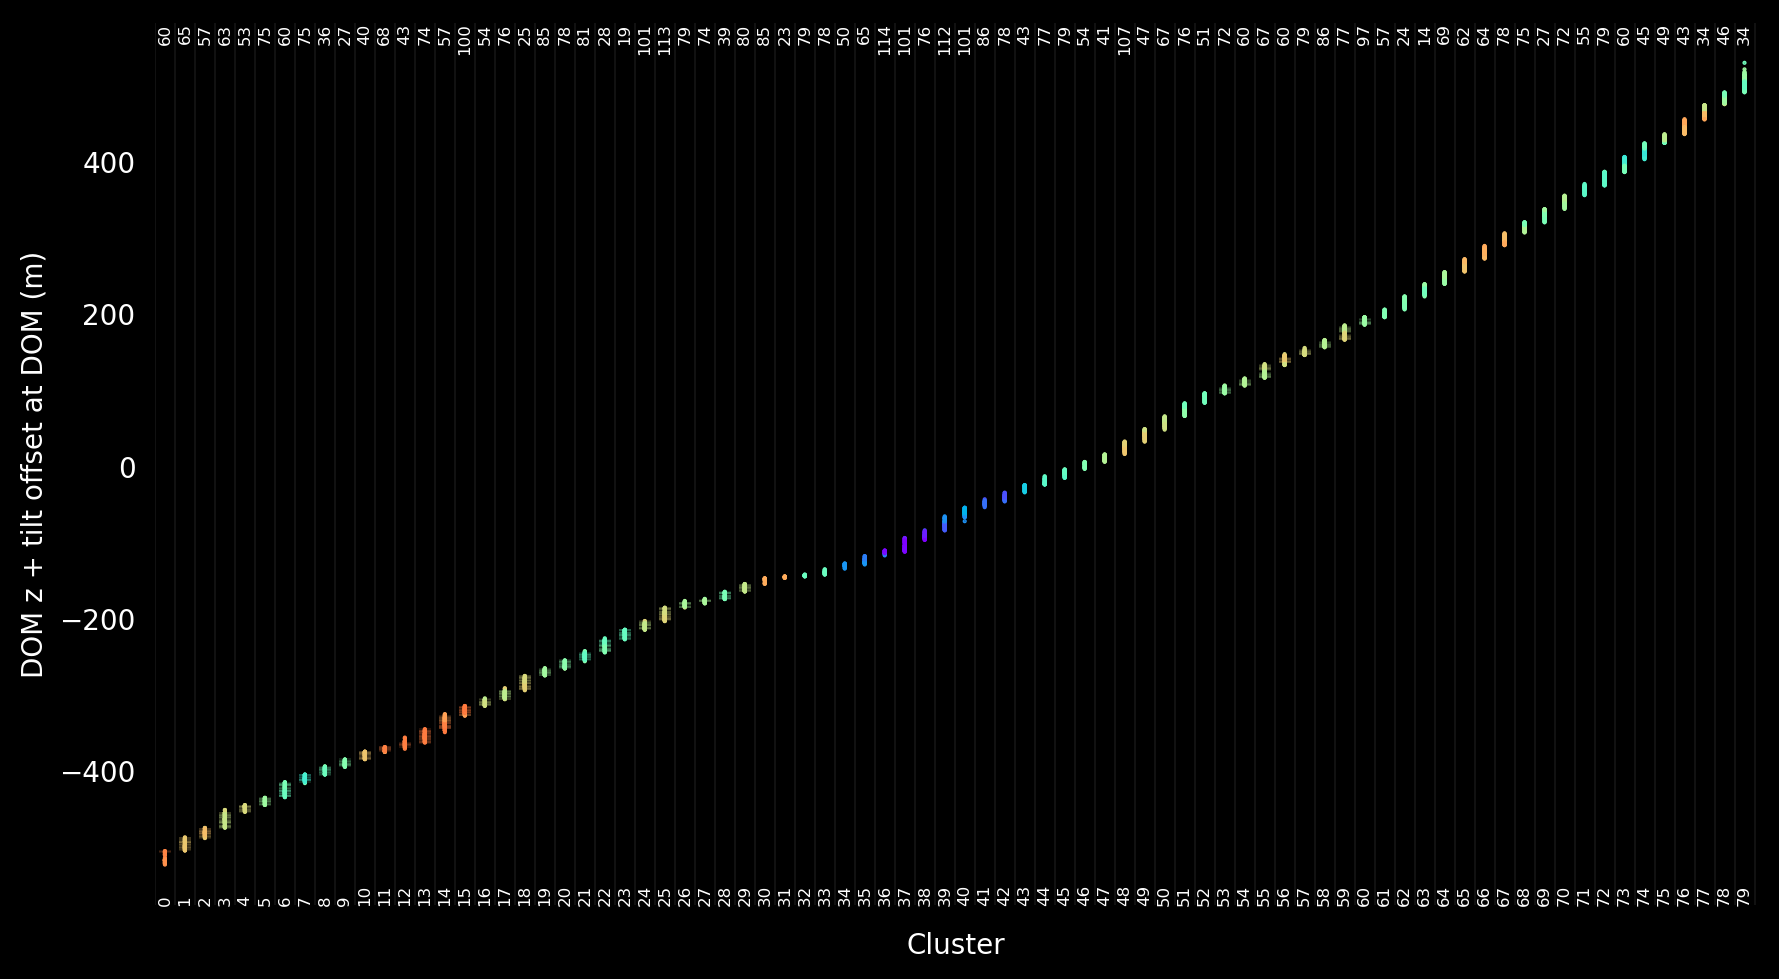

In [16]:
%%time

n_components = 80

clusterer = BayesianGaussianMixture(n_components=n_components)
clusterer.fit(sph_samps)
labels = clusterer.predict(sph_samps)

zlabs, zunq_labs, zunq_cnt = reorg_labels(labels, z=zequiv)

print 'Number of cluster labels (excluding "noise"):', np.sum(zunq_labs != -1)
print 'Number of DOMs classified as "noise":        ', np.sum(zlabs == -1)

fig, ax = plt.subplots(figsize=(9, 5), dpi=200)
plot_clusters(ax, zlabs, zequiv, al_sl, zunq_labs, zunq_cnt)
fig.tight_layout()

outfbase = join(outdir, 'bayesian_gaussian_mixture_{:d}'.format(n_components) + sign_convention)

clustermap = save_clustermap(outfbase + '.npy', zlabs)

fig.savefig(outfbase + '.pdf')
fig.savefig(outfbase + '.png', dpi=300)
pass

In [137]:
%%time

kw = dict(
    damping=0.5, # in [0.5, 1], default = 0.5
    max_iter=100000, # default = 200
    convergence_iter=15, # default = 15
    preference=None # scroe for prefering points as exemplars 
)

clusterer = AffinityPropagation(**kw)
clusterer.fit(sph_samps)
labels = clusterer.predict(sph_samps)

zlabs, zunq_labs, zunq_cnt = reorg_labels(labels, z=zequiv)

print 'Number of cluster labels (excluding "noise"):', np.sum(zunq_labs != -1)
print 'Number of DOMs classified as "noise":        ', np.sum(zlabs == -1)

Number of cluster labels (excluding "noise"): 107
Number of DOMs classified as "noise":         0
CPU times: user 13h 3min 1s, sys: 9.44 s, total: 13h 3min 11s
Wall time: 13h 3min 14s


In [138]:
clusterer.n_iter_

100000

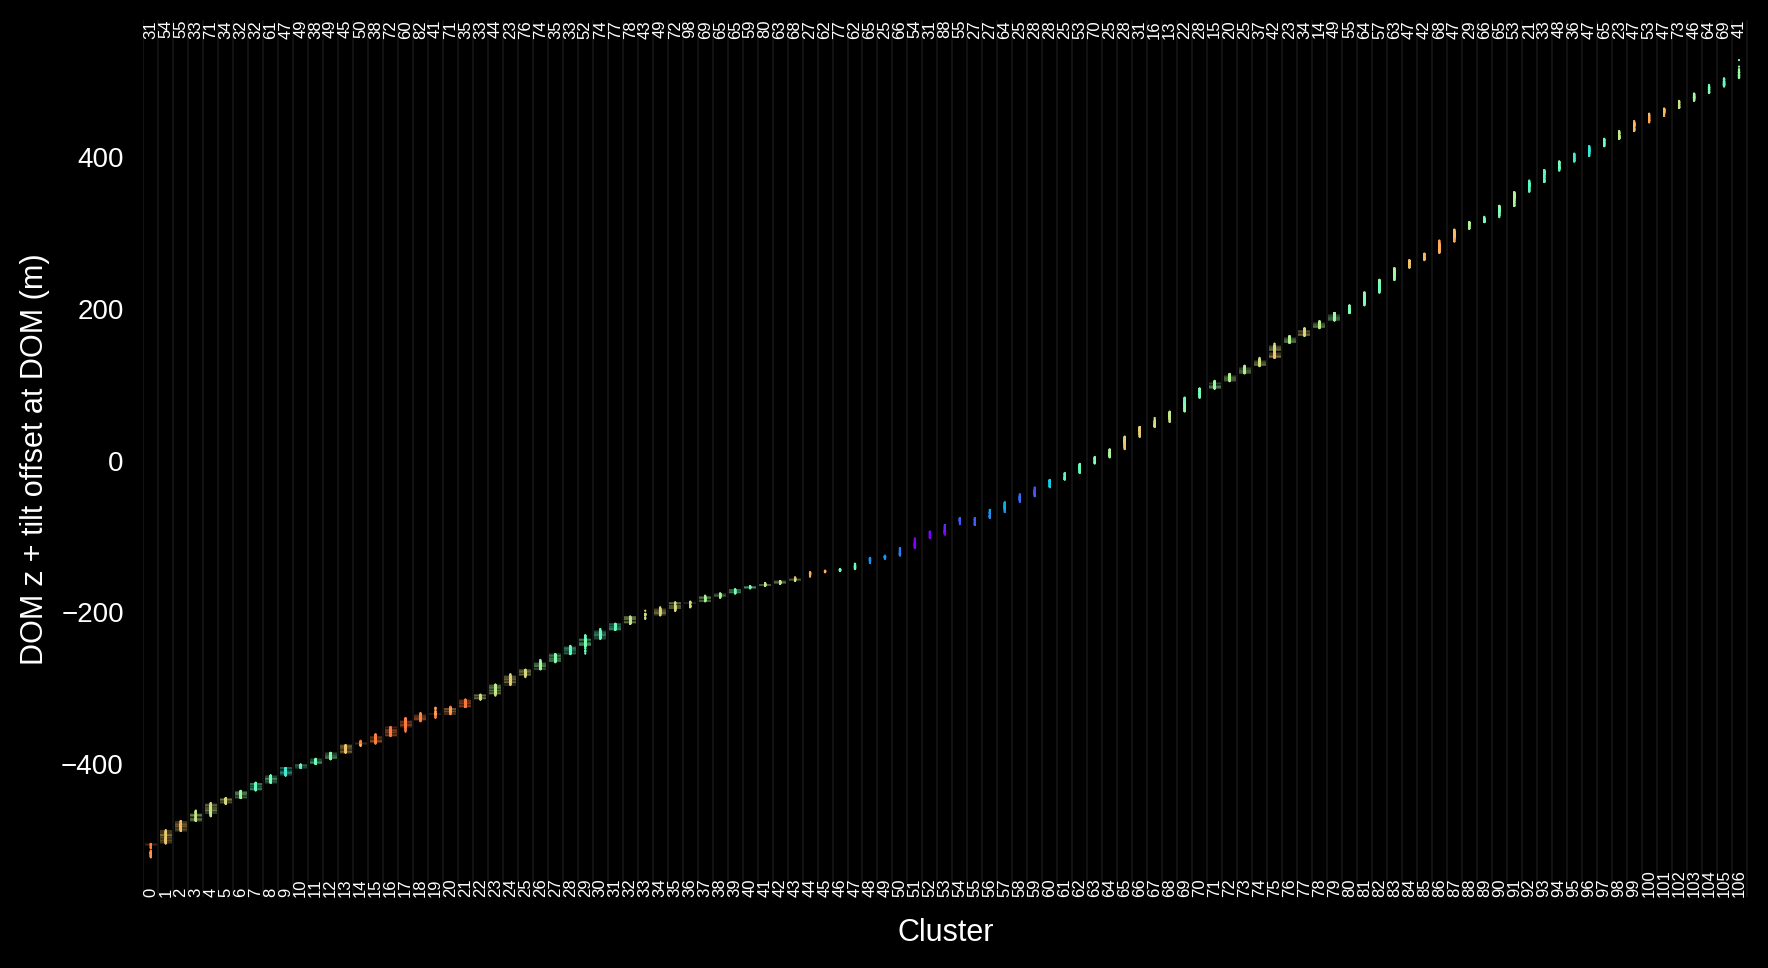

In [139]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=200)
plot_clusters(ax, zlabs, zequiv, al_sl, zunq_labs, zunq_cnt)
fig.tight_layout()

outfbase = join(outdir, 'affinity_propagation_dmp{damping}_maxit{max_iter}_cnvit{convergence_iter}'.format(**kw) + sign_convention)

clustermap = save_clustermap(outfbase + '.npy', zlabs)

fig.savefig(outfbase + '.pdf')
fig.savefig(outfbase + '.png', dpi=300)
pass

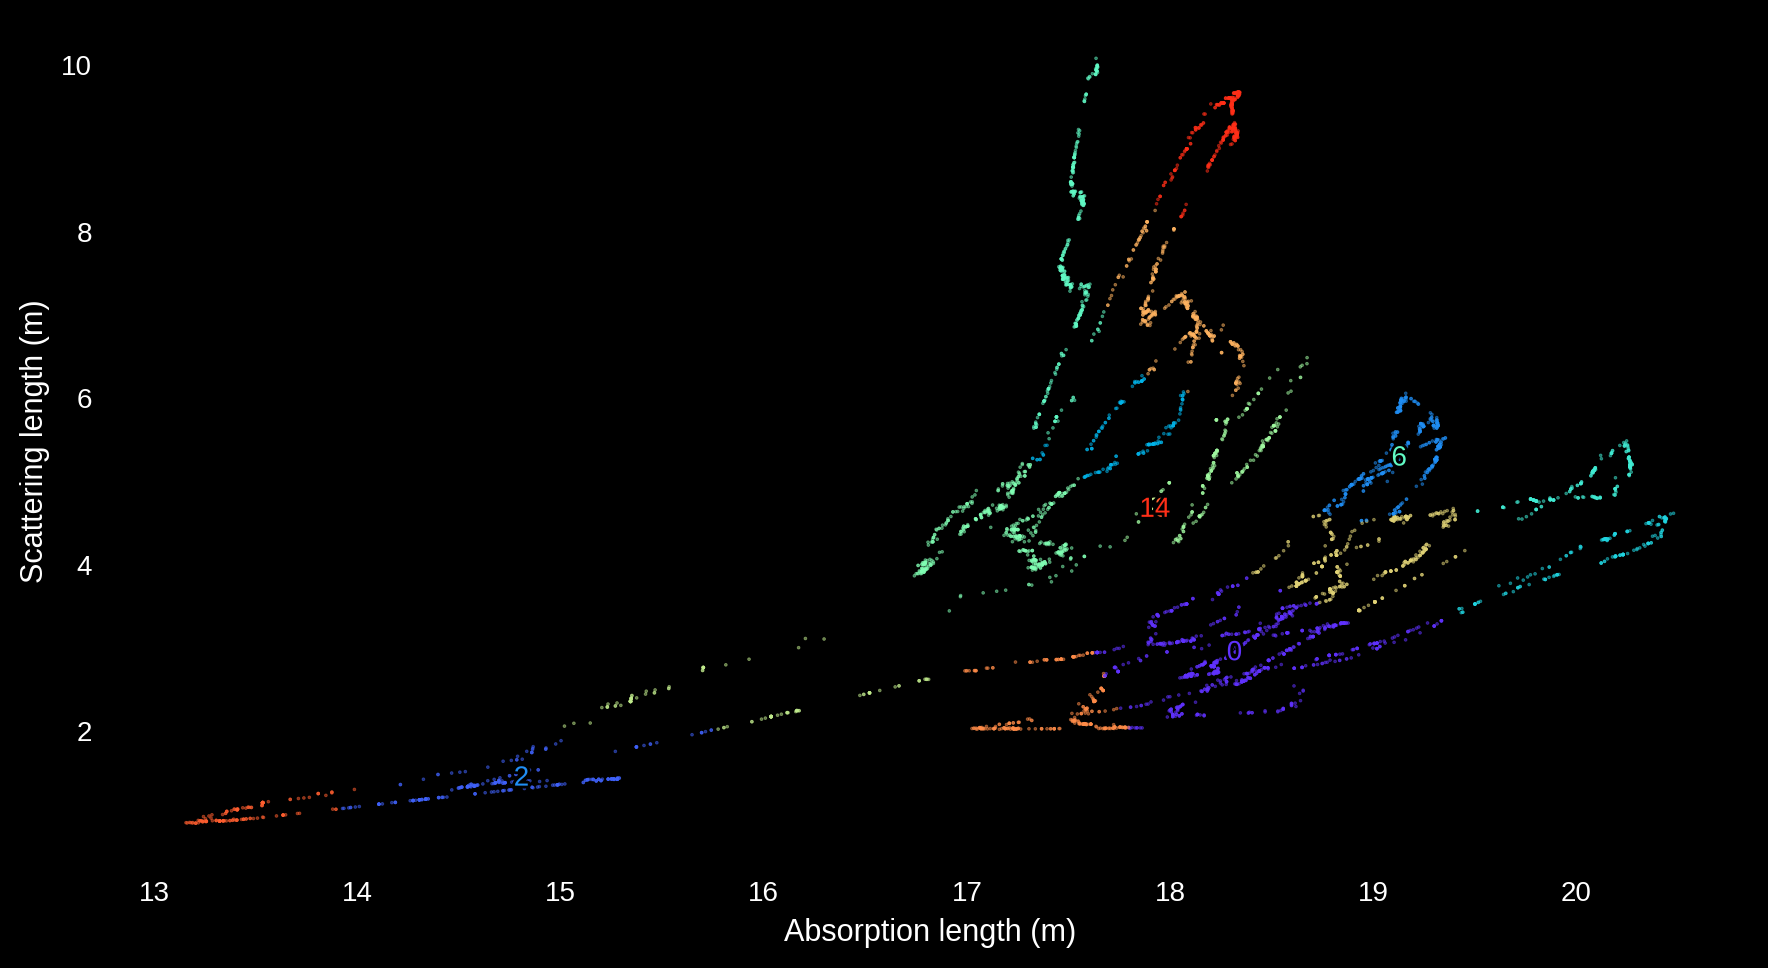

In [285]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=200)
palette = sns.color_palette(palette='rainbow', n_colors=len(unq_gmxopt_labs))
cluster_colors = [palette[col] for col in unq_gmxopt_inv]
rf = 0.0
ax.scatter(
    properties['abslen'] + rf*np.random.randn(5160),
    properties['scatlen'] + rf*np.random.randn(5160),
    c=cluster_colors, s=1, alpha=0.5
)

for lab, idxs in zip(unq_gmxopt_labs, unq_gmxopt_idxs):
    abslen_med = np.median(properties['abslen'][idxs])
    scatlen_med = np.median(properties['scatlen'][idxs])
    abslen_mean = np.mean(properties['abslen'][idxs])
    scatlen_mean = np.mean(properties['scatlen'][idxs])
    abslen_center, scatlen_center = gmix_opt.means_[lab]
    txt = ax.text(
        abslen_center, scatlen_center,
        format(lab, 'd'),
        va='center', ha='center',
        fontsize=10,
        #color='w',
        color=palette[lab]
    )
    txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

ax.grid(which='both', b=False)
ax.set_xlabel('Absorption length (m)')
ax.set_ylabel('Scattering length (m)')
#ax.axis('image')
fig.tight_layout()
pass

In [10]:
ls $outdir/*npy

cluster_doms_by_local_properties/affinity_propagation_dmp0.5_maxit100000_cnvit15.npy
cluster_doms_by_local_properties/affinity_propagation_dmp0.5_maxit10000_cnvit15.npy
cluster_doms_by_local_properties/affinity_propagation_dmp0.5_maxit1000_cnvit15.npy
cluster_doms_by_local_properties/affinity_propagation_dmp0.5_maxit200_cnvit15.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_100.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_100_opposite.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_120.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_120_opposite.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_40.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_60.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_80.npy
cluster_doms_by_local_properties/bayesian_gaussian_mixture_80_opposite.npy
cluster_doms_by_local_properties/gaussian_mixture_100.npy
cluster_doms_by_local_properties/gaussian_mixture

In [775]:
clusters = np.load(join(outdir, 'bayesian_gaussian_mixture_80.npy'))

In [776]:
clusters

array([( 1,  1, 79), ( 2,  1, 79), ( 3,  1, 79), ..., (84, 60,  0),
       (85, 60,  1), (86, 60,  1)],
      dtype=[('string', '<u4'), ('dom', '<u4'), ('label', '<i4')])

In [774]:
#clusters = np.sort(clusters, order=['label', 'string', 'dom'])
cluster_omkey_mapping = OrderedDict()
for label in sorted(np.unique(clusters['label'])):
    omkeys = clusters[clusters['label'] == label][['string', 'dom']]
    np.save('/data/icecube/retro/tables/tilt_on_anisotropy_on_noazimuth_80/cl{}/omkeys.npy'.format(label), omkeys)
    cluster_omkey_mapping[label] = omkeys

In [770]:
clusters.shape

(5160,)

In [12]:
string_dom = clusters[['string', 'dom']]
labels = clusters['label']
sd = np.array([(86, 45)], dtype=string_dom.dtype)
label = labels[string_dom == sd]
members = string_dom[labels == label]
print '(string, dom) {} is a member of group {}'.format(sd, label)
print 'all members:\n', members

(string, dom) [(86, 45)] is a member of group [8]
all members:
[(79, 45) (80, 45) (83, 45) (84, 45) (85, 45) (86, 45) (80, 46) (81, 46)
 (82, 46) (83, 46) (85, 46) (86, 46) ( 3, 53) ( 4, 53) (10, 53) (16, 53)
 (17, 53) (33, 53) (52, 53) ( 6, 54) (12, 54) (13, 54) (19, 54) (20, 54)
 (28, 54) (35, 54) (36, 54) (45, 54) (54, 54) (61, 54) (62, 54) (68, 54)
 (69, 54) (29, 55) (47, 55) (56, 55) (70, 55) (71, 55) (76, 55) (77, 55)
 (21, 56) (40, 56) (49, 56) (50, 56) (57, 56) (58, 56) (72, 56) (73, 56)
 (78, 56) (66, 57)]


In [13]:
print 'unique strings:', np.unique(members['string'])
print 'unique doms   :', np.unique(members['dom'])

unique strings: [ 3  4  6 10 12 13 16 17 19 20 21 28 29 33 35 36 40 45 47 49 50 52 54 56
 57 58 61 62 66 68 69 70 71 72 73 76 77 78 79 80 81 82 83 84 85 86]
unique doms   : [45 46 53 54 55 56 57]


In [14]:
s_idx_d_idx = members.view(np.uint32).reshape((len(members), 2)) - 1

In [15]:
np.sort(members, order='string')
for member in np.sort(members, order='string'):
    sys.stdout.write('"{} {}" '.format(member['string'], member['dom']))

"3 53" "4 53" "6 54" "10 53" "12 54" "13 54" "16 53" "17 53" "19 54" "20 54" "21 56" "28 54" "29 55" "33 53" "35 54" "36 54" "40 56" "45 54" "47 55" "49 56" "50 56" "52 53" "54 54" "56 55" "57 56" "58 56" "61 54" "62 54" "66 57" "68 54" "69 54" "70 55" "71 55" "72 56" "73 56" "76 55" "77 55" "78 56" "79 45" "80 45" "80 46" "81 46" "82 46" "83 45" "83 46" "84 45" "85 45" "85 46" "86 45" "86 46" 

In [16]:
len(members)

50

## Check how close summed tables are to component tables

Note: used `bayesian_gaussian_mixture_80.npy` to define clusters.

In [17]:
ddir = '/data/icecube/retro_tables/tilt_on_anisotropy_on_noazimuth/'

Load summed table as reference

In [18]:
label = 0
members = np.sort(clusters[clusters['label'] == label][['string', 'dom']], order=('string', 'dom'))
print(len(members))

41


In [300]:
refdir = join('/data/icecube/retro_tables/tilt_on_anisotropy_on_noazimuth_80', 'cl{}'.format(label))
print('refdir:', refdir)

('refdir:', '/data/icecube/retro_tables/tilt_on_anisotropy_on_noazimuth_80/cl0')


In [625]:
%%time
reftbl = np.load(join(refdir, 'table.npy'))
ref_n_photons = np.load(join(refdir, 'n_photons.npy'))
slice_all = (slice(1, -1),)*reftbl.ndim
reftbl = reftbl[slice_all] #/ len(members)
print(reftbl.shape, reftbl.size)

((80, 40, 100, 40, 40), 512000000)
CPU times: user 0 ns, sys: 1.78 s, total: 1.78 s
Wall time: 1.78 s


In [389]:
r_be = np.load(join(refdir, 'r_bin_edges.npy'))
ct_be = np.load(join(refdir, 'costheta_bin_edges.npy'))
dt_be = np.load(join(refdir, 't_bin_edges.npy'))
ctdir_be = np.load(join(refdir, 'costhetadir_bin_edges.npy'))
dpdir_be = np.load(join(refdir, 'deltaphidir_bin_edges.npy'))

r_bins = OneDimBinning(name='r', bin_edges=r_be, units='m')
ct_bins = OneDimBinning(name='ct', tex=r'\cos\,\theta', bin_edges=ct_be)
dt_bins = OneDimBinning(name='dt', tex=r'\Delta t', bin_edges=dt_be, units='ns')
ctdir_bins = OneDimBinning(name='ctdir', tex=r'\cos\,\theta_{\rm dir}', bin_edges=ctdir_be)
dpdir_bins = OneDimBinning(name='dpdir', tex=r'|\Delta\phi_{\rm dir}|', bin_edges=dpdir_be, units='rad')

binning = r_bins * ct_bins * dt_bins * ctdir_bins * dpdir_bins
for d in binning:
    pwrstr = ''
    try:
        pwr = infer_power(d.bin_edges)
    except ValueError:
        pwr = 1
    if pwr != 1:
        pwrstr = ' power={}'.format(pwr)
    print(
        '{}: domain=[{}, {}]{}, {} bins{}'.format(
            d.name, d.domain.m[0], d.domain.m[1], ' {:~}'.format(d.domain.u).rstrip(), d.num_bins, pwrstr
    ))

r: domain=[0.0, 200.0] m, 80 bins power=2.0
ct: domain=[-1.0, 1.0], 40 bins
dt: domain=[0.0, 4000.0] ns, 100 bins power=2.0
ctdir: domain=[-1.0, 1.0], 40 bins
dpdir: domain=[0.0, 3.14159265359] rad, 40 bins


In [623]:
reftbl.max()

79448410.0

In [626]:
%%time
#mask = (srctbl + reftbl) != 0
mask = reftbl != 0
num_nonzero = np.sum(mask)
print('num_nonzero:', num_nonzero, 'fract_nonzero:', num_nonzero / mask.size)

('num_nonzero:', 450100280, 'fract_nonzero:', 0.879102109375)
CPU times: user 1.25 s, sys: 260 ms, total: 1.51 s
Wall time: 1.51 s


$\chi^2 = ({\rm actual} - {\rm expected})^2 / {\rm expected}$

In [487]:
dist_be = np.logspace(np.log10(1e-20), np.log10(2000000), 10001)

In [624]:
%%time
ref_hist, ref_hist_be = np.histogram(reftbl, bins=dist_be, density=False)

CPU times: user 28.1 s, sys: 1.02 s, total: 29.1 s
Wall time: 29.1 s


In [743]:
%%time
scaled_ref_hist, _ = np.histogram(reftbl * (src_n_photons / ref_n_photons), bins=dist_be, density=False)

CPU times: user 29.5 s, sys: 2.07 s, total: 31.6 s
Wall time: 31.6 s


In [526]:
%%time

bin_edges = np.linspace(0, 2000, 10001)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

chi2_hists = OrderedDict()
src_hists = OrderedDict()
num_members = len(members)
for member_i in range(num_members):
    t0 = time.time()
    string, dom = members[member_i].item()
    sd = (int(string), int(dom))
    sys.stdout.write('member {:3d}/{:3d}: ({:2d}, {:2d})\n'.format(member_i, num_members, string, dom))
    sys.stdout.flush()
    fpath = join(
        ddir,
        'clsim_table_set_b8e6e072_string_{}_dom_{}_seed_0_n_10000.fits'.format(string, dom)
    )
    srctbl_all = load_clsim_table_minimal(fpath)
    srctbl = srctbl_all['table'][slice_all]

    #chi2 = (np.square(srctbl - reftbl) / (srctbl + reftbl))[mask]
    chi2 = np.square(srctbl[mask] - reftbl[mask]) / reftbl[mask]
    
    chi2_hist, _ = np.histogram(chi2, bins=bin_edges, density=False)
    chi2_hists[sd] = chi2_hist
    src_hist, _ = np.histogram(srctbl, bins=dist_be, density=False)
    src_hists[sd] = src_hist
    sys.stdout.write(' ... {:.1f} sec for DOM table\n'.format(time.time() - t0))

member   0/ 41: ( 1, 60)


    (load took 2.226 s)


 ... 70.0 sec for DOM tablemember   1/ 41: ( 2, 60)


    (load took 2.093 s)


 ... 68.9 sec for DOM tablemember   2/ 41: ( 3, 60)


    (load took 9.617 s)


 ... 77.7 sec for DOM tablemember   3/ 41: ( 4, 60)


    (load took 9.753 s)


 ... 77.0 sec for DOM tablemember   4/ 41: ( 5, 60)


    (load took 10.006 s)


 ... 80.5 sec for DOM tablemember   5/ 41: ( 6, 60)


    (load took 9.637 s)


 ... 78.9 sec for DOM tablemember   6/ 41: ( 7, 60)


    (load took 10.016 s)


 ... 80.5 sec for DOM tablemember   7/ 41: ( 8, 60)


    (load took 10.104 s)


 ... 79.7 sec for DOM tablemember   8/ 41: ( 9, 60)


    (load took 9.78 s)


 ... 76.6 sec for DOM tablemember   9/ 41: (10, 59)


    (load took 8.336 s)


 ... 73.7 sec for DOM tablemember  10/ 41: (10, 60)


    (load took 8.218 s)


 ... 74.1 sec for DOM tablemember  11/ 41: (11, 60)


    (load took 8.487 s)


 ... 74.8 sec for DOM tablemember  12/ 41: (12, 60)


    (load took 8.845 s)


 ... 76.3 sec for DOM tablemember  13/ 41: (14, 60)


    (load took 8.454 s)


 ... 75.4 sec for DOM tablemember  14/ 41: (15, 60)


    (load took 8.588 s)


 ... 75.8 sec for DOM tablemember  15/ 41: (16, 60)


    (load took 9.659 s)


 ... 77.2 sec for DOM tablemember  16/ 41: (17, 60)


    (load took 9.524 s)


 ... 77.9 sec for DOM tablemember  17/ 41: (18, 60)


    (load took 9.849 s)


 ... 79.1 sec for DOM tablemember  18/ 41: (19, 60)


    (load took 9.896 s)


 ... 75.4 sec for DOM tablemember  19/ 41: (22, 60)


    (load took 9.638 s)


 ... 76.2 sec for DOM tablemember  20/ 41: (23, 60)


    (load took 9.786 s)


 ... 78.5 sec for DOM tablemember  21/ 41: (24, 60)


    (load took 9.771 s)


 ... 77.1 sec for DOM tablemember  22/ 41: (25, 60)


    (load took 10.23 s)


 ... 76.7 sec for DOM tablemember  23/ 41: (26, 60)


    (load took 10.243 s)


 ... 77.8 sec for DOM tablemember  24/ 41: (27, 60)


    (load took 10.471 s)


 ... 79.8 sec for DOM tablemember  25/ 41: (31, 60)


    (load took 10.787 s)


 ... 77.2 sec for DOM tablemember  26/ 41: (32, 60)


    (load took 10.376 s)


 ... 76.8 sec for DOM tablemember  27/ 41: (33, 60)


    (load took 10.191 s)


 ... 75.4 sec for DOM tablemember  28/ 41: (35, 60)


    (load took 10.152 s)


 ... 78.0 sec for DOM tablemember  29/ 41: (41, 60)


    (load took 10.226 s)


 ... 77.8 sec for DOM tablemember  30/ 41: (42, 60)


    (load took 10.464 s)


 ... 79.9 sec for DOM tablemember  31/ 41: (43, 60)


    (load took 10.227 s)


 ... 77.3 sec for DOM tablemember  32/ 41: (44, 60)


    (load took 10.233 s)


 ... 81.0 sec for DOM tablemember  33/ 41: (45, 60)


    (load took 10.116 s)


 ... 80.0 sec for DOM tablemember  34/ 41: (51, 60)


    (load took 9.88 s)


 ... 77.1 sec for DOM tablemember  35/ 41: (52, 60)


    (load took 10.203 s)


 ... 79.4 sec for DOM tablemember  36/ 41: (53, 60)


    (load took 10.205 s)


 ... 79.7 sec for DOM tablemember  37/ 41: (60, 60)


    (load took 10.544 s)


 ... 76.7 sec for DOM tablemember  38/ 41: (61, 60)


    (load took 10.177 s)


 ... 77.7 sec for DOM tablemember  39/ 41: (79, 60)


    (load took 9.931 s)


 ... 77.2 sec for DOM tablemember  40/ 41: (84, 60)


    (load took 9.818 s)


 ... 76.1 sec for DOM tableCPU times: user 42min 34s, sys: 6min 37s, total: 49min 12s
Wall time: 52min 43s


In [620]:
src_n_photons = srctbl_all['n_photons']

In [601]:
oldtbl = np.load('/home/icecube/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_59/table.npy')[slice_all]

In [605]:
old_n_photons = np.load('/home/icecube/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_59/n_photons.npy')

In [604]:
%%time
old_hist, _ = np.histogram(oldtbl, bins=dist_be, density=False)

CPU times: user 2min 40s, sys: 9.78 s, total: 2min 50s
Wall time: 2min 50s


In [629]:
ref_n_photons / src_n_photons

41.0

In [649]:
fpath = '/data/icecube/retro_tables/tilt_on_anisotropy_on_noazimuth_bugfix/clsim_table_set_b8e6e072_string_84_dom_60_seed_0_n_10000.fits'

bf1tbl_all = load_clsim_table_minimal(fpath)
bf1tbl = bf1tbl_all['table'][slice_all]
bf1_n_photons = bf1tbl_all['n_photons']

    (load took 2.27 s)


In [653]:
%%time
bf1_hist, _ = np.histogram(bf1tbl, bins=dist_be, density=False)

CPU times: user 24.7 s, sys: 1.82 s, total: 26.5 s
Wall time: 26.5 s


In [755]:
bf1tbl_sum / srctbl_sum

0.10838443

In [756]:
%%time
scaled_bf1_hist, _ = np.histogram(bf1tbl*srctbl_sum/bf1tbl_sum, bins=dist_be, density=False)

CPU times: user 27.4 s, sys: 2.11 s, total: 29.5 s
Wall time: 29.4 s


In [730]:
%%time

fpath = '/data/icecube/retro_tables/tilt_on_anisotropy_on_noazimuth_bugfix2/clsim_table_set_b8e6e072_string_84_dom_60_seed_0_n_10000.fits'

bf2tbl_all = load_clsim_table_minimal(fpath)
bf2tbl = bf2tbl_all['table'][slice_all]
bf2_n_photons = bf2tbl_all['n_photons']
bf2_hist, _ = np.histogram(bf2tbl, bins=dist_be, density=False)

    (load took 2.234 s)


CPU times: user 25.7 s, sys: 2.72 s, total: 28.4 s
Wall time: 28.4 s


In [731]:
bf2tbl_sum = np.sum(bf2tbl)

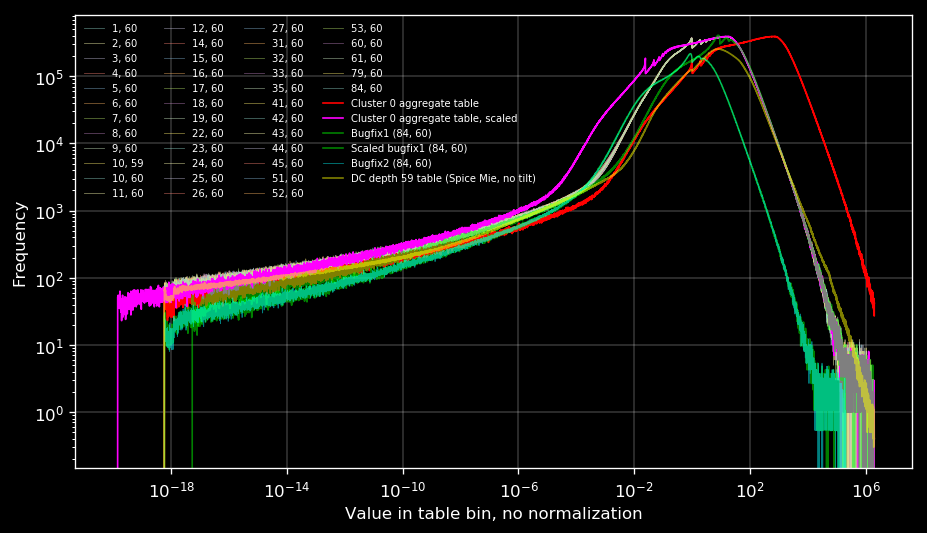

In [757]:
plt.close('all')
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)

for sd, src_hist in src_hists.items():
    ax.step(dist_be, [src_hist[0]] + src_hist.tolist(), lw=0.5, alpha=0.5, label='{}, {}'.format(*sd))
    #break

ax.step(
    dist_be,
    np.array([ref_hist[0]] + ref_hist.tolist()), # * src_n_photons / ref_n_photons,
    lw=1, c='r',
    label='Cluster {} aggregate table'.format(label)
)
ax.step(
    dist_be,
    np.array([scaled_ref_hist[0]] + scaled_ref_hist.tolist()), # * src_n_photons / ref_n_photons,
    lw=1, c=(1,0,1),
    label='Cluster {} aggregate table, scaled'.format(label)
)
ax.step(
    dist_be,
    np.array([bf1_hist[0]] + bf1_hist.tolist()) * src_n_photons / bf1_n_photons,
    lw=1, alpha=0.5, c=(0,1,0),
    label='Bugfix1 (84, 60)'
)
ax.step(
    dist_be,
    np.array([scaled_bf1_hist[0]] + scaled_bf1_hist.tolist()),
    lw=1, alpha=0.5, c=(0,1,0),
    label='Scaled bugfix1 (84, 60)'
)
ax.step(
    dist_be,
    np.array([bf2_hist[0]] + bf2_hist.tolist()) * src_n_photons / bf2_n_photons,
    lw=0.5, ls=':', alpha=0.5, c=(0,1,1),
    label='Bugfix2 (84, 60)'
)
ax.step(
    dist_be,
    np.array([old_hist[0]] + old_hist.tolist()) * src_n_photons / old_n_photons,
    lw=1, alpha=0.5, c=(1,1,0),
    label='DC depth 59 table (Spice Mie, no tilt)'
)
    
#ax.set_xlim(1e-2, 0.7)
#ax.set_ylim(1e5, 3.0e5)
#xt = np.arange(1/num_members, 0.7, 1/num_members)
#ax.set_xticks(xt)
#ax.set_xticklabels(range(1, len(xt) + 1))
ax.grid(True, lw=0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best', ncol=4, fontsize=6, frameon=False)
ax.set_xlabel(r'Value in table bin, no normalization')
ax.set_ylabel('Frequency')
pass

In [758]:
ref_n_photons

array(4.10002681e+09)

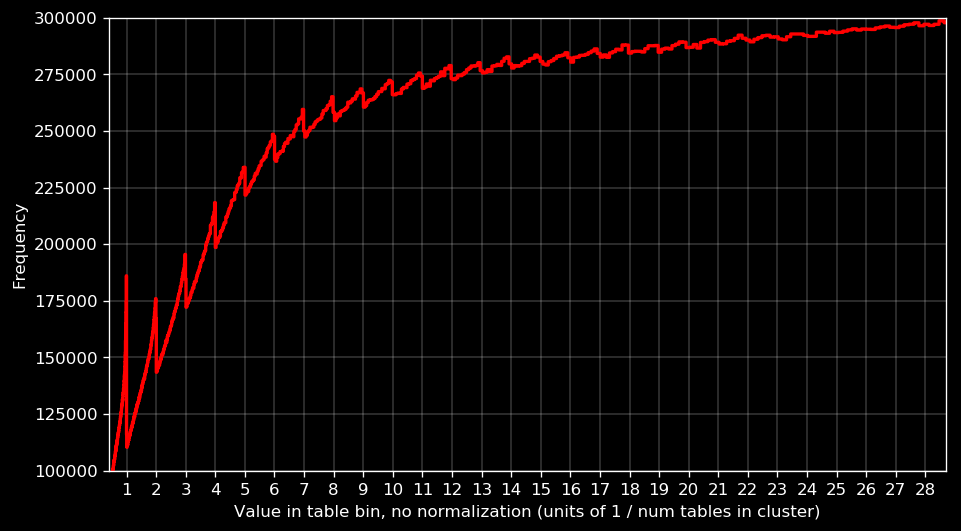

In [590]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.step(ref_hist_be, [ref_hist[0]] + ref_hist.tolist(), lw=2, c='r', label='Cluster {} aggregate table'.format(label))

# for sd, src_hist in src_hists.items():
#     ax.step(dist_be, [src_hist[0]] + src_hist.tolist(), lw=1, alpha=1, label='Table ({}, {})'.format(*sd))
#     #break
    
ax.set_xlim(1e-2, 0.7)
ax.set_ylim(1e5, 3.0e5)
xt = np.arange(1/num_members, 0.7, 1/num_members)
ax.set_xticks(xt)
ax.set_xticklabels(range(1, len(xt) + 1))
ax.grid(True, lw=0.2)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.legend(loc='best', ncol=4, fontsize=8, frameon=False)
ax.set_xlabel(r'Value in table bin, no normalization (units of 1 / num tables in cluster)')
ax.set_ylabel('Frequency')
pass

In [630]:
members

array([( 1, 60), ( 2, 60), ( 3, 60), ( 4, 60), ( 5, 60), ( 6, 60),
       ( 7, 60), ( 8, 60), ( 9, 60), (10, 59), (10, 60), (11, 60),
       (12, 60), (14, 60), (15, 60), (16, 60), (17, 60), (18, 60),
       (19, 60), (22, 60), (23, 60), (24, 60), (25, 60), (26, 60),
       (27, 60), (31, 60), (32, 60), (33, 60), (35, 60), (41, 60),
       (42, 60), (43, 60), (44, 60), (45, 60), (51, 60), (52, 60),
       (53, 60), (60, 60), (61, 60), (79, 60), (84, 60)],
      dtype=[('string', '<u4'), ('dom', '<u4')])

In [638]:
print [len(np.unique(clusters[clusters['label'] == i]['dom'])) for i in np.sort(np.unique(clusters['label']))]

[2, 3, 5, 8, 8, 7, 9, 7, 7, 7, 7, 6, 5, 6, 8, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 7, 4, 4, 5, 4, 3, 2, 1, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 4, 4, 3, 4, 3, 6, 4, 4, 3, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]


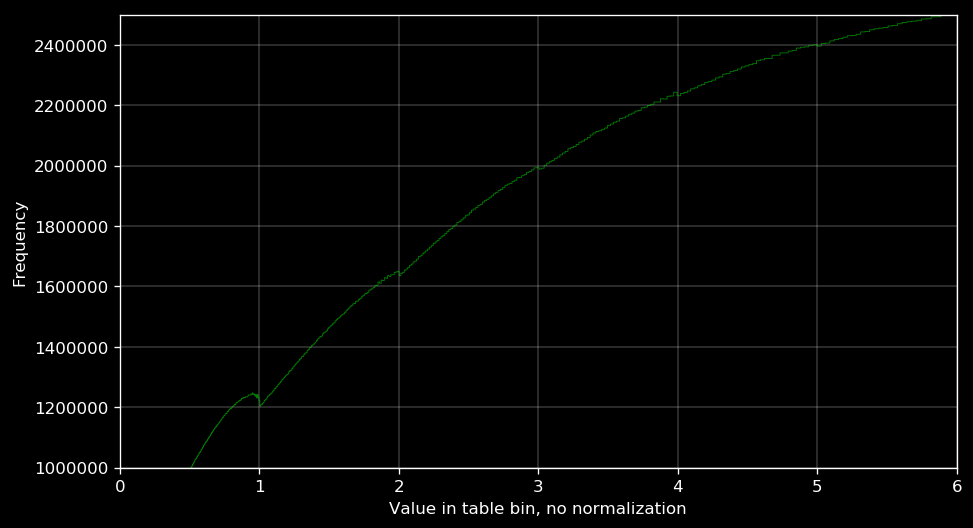

In [619]:
plt.close('all')
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.step(dist_be, [old_hist[0]] + old_hist.tolist(), lw=0.5, alpha=0.5, c=(0,1,0), label='DC depth 59 table (Spice Mie, no tilt)')

xmax = 6
ax.set_xlim(0, xmax)
ax.set_ylim(1e6, 2.5e6)
xt = np.arange(0, xmax+1, 1)
ax.set_xticks(xt)
#ax.set_xticklabels(range(1, len(xt) + 1))
ax.grid(True, lw=0.2)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.legend(loc='best', ncol=4, fontsize=8, frameon=False)
ax.set_xlabel(r'Value in table bin, no normalization')
ax.set_ylabel('Frequency')
pass

In [574]:
num_members

41

In [650]:
np.sum(bf1tbl == 0)

216857858

In [652]:
bf1_n_photons / src_n_photons

1.87221652292107

In [648]:
np.sum(srctbl == 0)

127733647

In [658]:
src_n_photons / bf1_n_photons

0.5341262550336752

In [751]:
bf1tbl_sum = np.sum(bf1tbl)
srctbl_sum = np.sum(srctbl)
print(bf1tbl_sum / srctbl_sum)

0.10838443


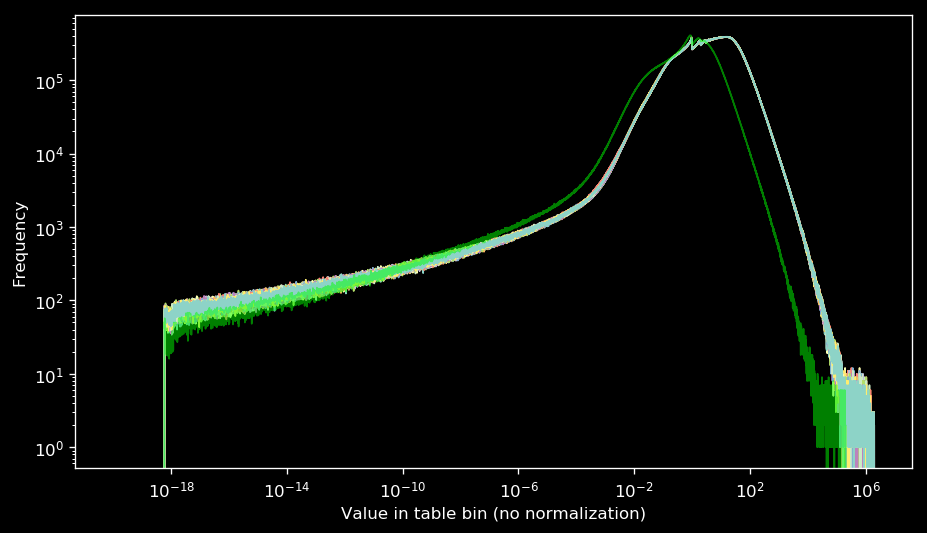

In [753]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
#ax.step(ref_hist_be, [ref_hist[0]] + ref_hist.tolist(), lw=2, c='r', label='Cluster {} aggregate table'.format(label))

for sd, src_hist in src_hists.items():
    ax.step(dist_be, [src_hist[0]] + src_hist.tolist(), lw=1, alpha=1, label='Table ({}, {})'.format(*sd))
    #break

ax.step(
    dist_be,
    np.array([bf1_hist[0]] + bf1_hist.tolist()),# * src_n_photons / bf1_n_photons,
    lw=1, alpha=0.5, c=(0,1,0),
    label='Bugfix1 (84, 60)'
)

# ax.set_xlim(0., 6)
# ax.set_ylim(2.5e5, 4.1e5)
# ax.set_xticks(np.arange(1, 20))
# ax.grid(True, lw=0.2)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.legend(loc='best', ncol=4, fontsize=8, frameon=False)
ax.set_xlabel(r'Value in table bin (no normalization)')
ax.set_ylabel('Frequency')
pass

In [682]:
print(src_n_photons / bf1_n_photons)
print(srctbl_sum / bf1tbl_sum)

0.534126255034
9.226418


In [694]:
norm = srctbl_sum / bf1tbl_sum# * bf1_n_photons / src_n_photons
print(norm)

9.226418


In [736]:
axes = (1,2,3,4)
srctbl_r = srctbl.sum(axis=axes)
bf1tbl_r = bf1tbl.sum(axis=axes)
bf2tbl_r = bf2tbl.sum(axis=axes)

In [737]:
axes = (0,1,3,4)
srctbl_t = srctbl.sum(axis=axes)
bf1tbl_t = bf1tbl.sum(axis=axes)
bf2tbl_t = bf2tbl.sum(axis=axes)

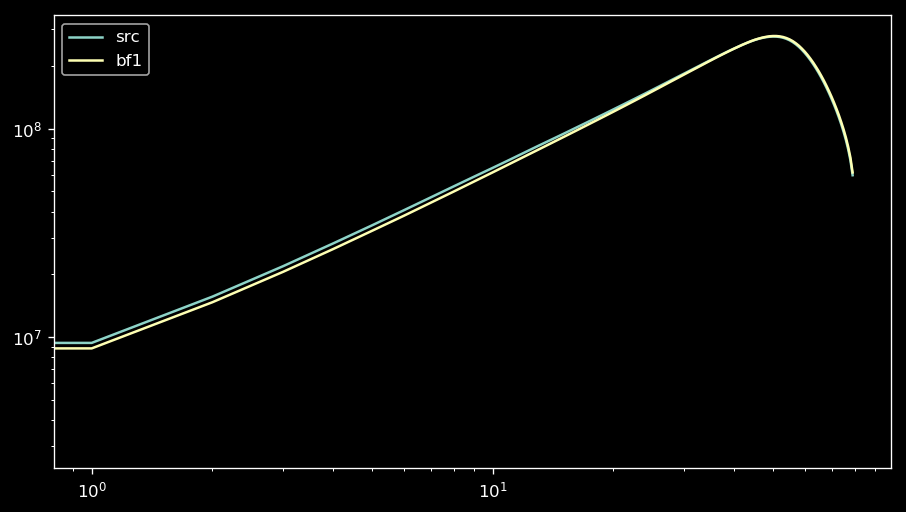

In [704]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.plot(srctbl_r, label='src')
ax.plot(bf1tbl_r * norm, label='bf1')
ax.legend(loc='best')
ax.set_xscale('log')
ax.set_yscale('log')

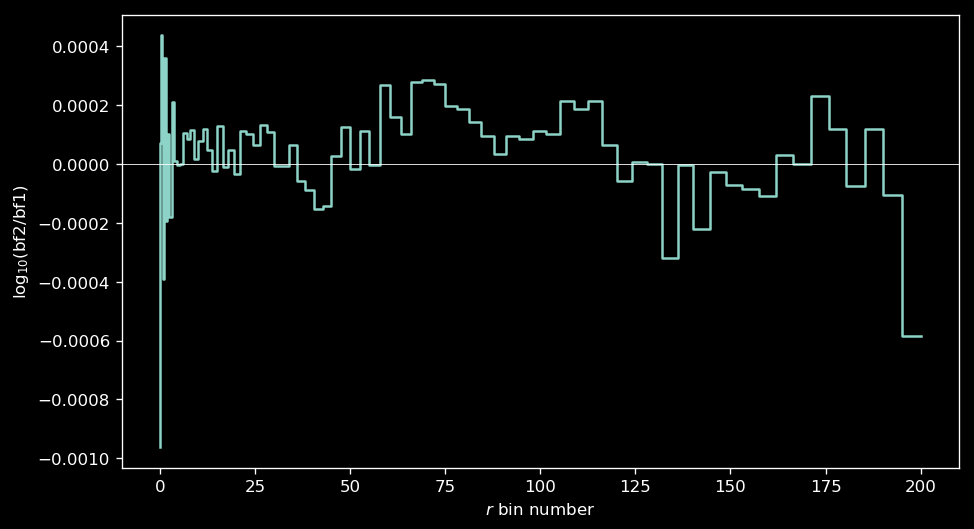

In [742]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
y = np.log10(bf2tbl_r / bf1tbl_r)
ax.step(r_be, [y[0]] + y.tolist())
xlim = ax.get_xlim()
ax.plot(xlim, [0]*2, 'w-', lw=0.5)
ax.set_xlim(xlim)
#ax.set_ylim(-.015, .005)
ax.set_ylabel(r'$\log_{10}({\rm bf2}/{\rm bf1})$')
ax.set_xlabel(r'$r$ bin number')
pass

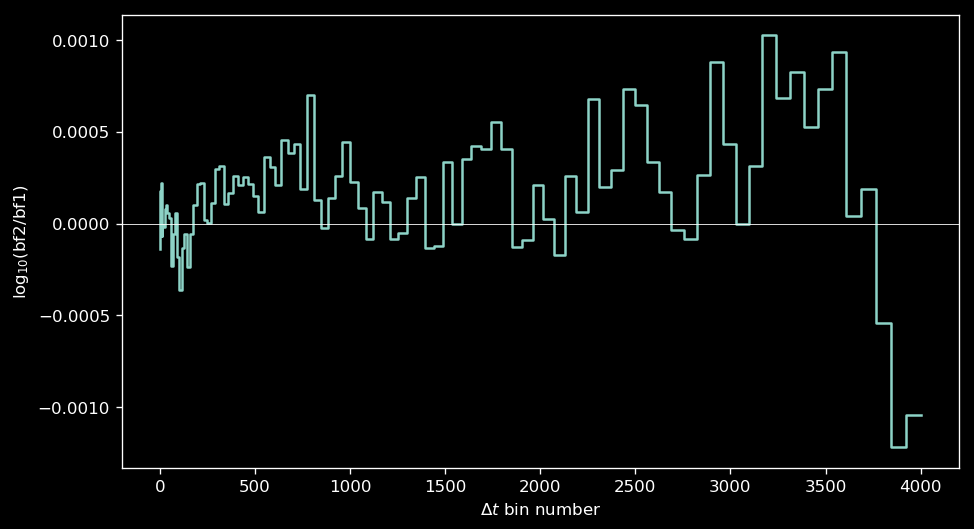

In [741]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
y = np.log10(bf2tbl_t / bf1tbl_t)
ax.step(dt_be, [y[0]] + y.tolist())
xlim = ax.get_xlim()
ax.plot(xlim, [0]*2, 'w-', lw=0.5)
ax.set_xlim(xlim)
#ax.set_ylim(-.04, .005)
ax.set_ylabel(r'$\log_{10}({\rm bf2}/{\rm bf1})$')
ax.set_xlabel(r'$\Delta t$ bin number')
pass

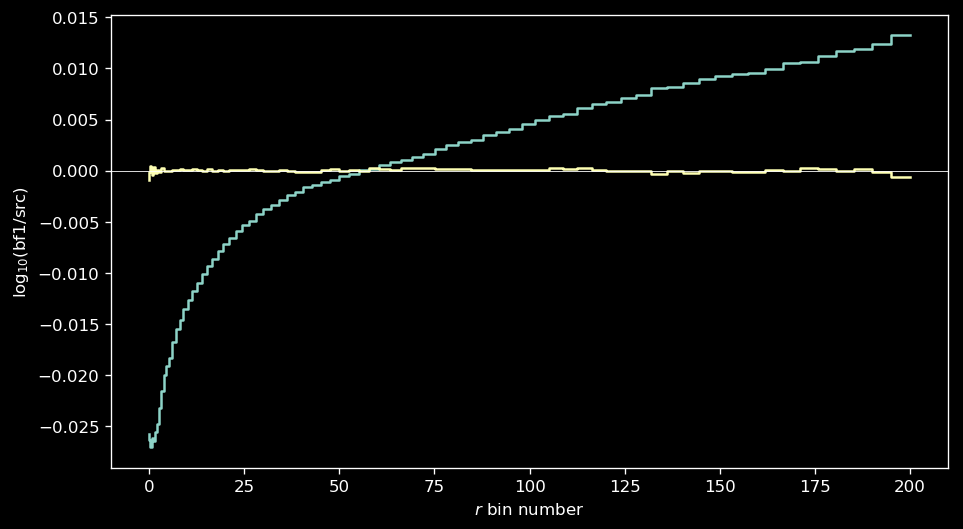

In [738]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
y = np.log10(bf1tbl_r*norm / srctbl_r)
ax.step(r_be, [y[0]] + y.tolist())
y = np.log10(bf2tbl_r / bf1tbl_r)
ax.step(r_be, [y[0]] + y.tolist())
xlim = ax.get_xlim()
ax.plot(xlim, [0]*2, 'w-', lw=0.5)
ax.set_xlim(xlim)
#ax.set_ylim(-.015, .005)
ax.set_ylabel(r'$\log_{10}({\rm bf1}/{\rm src})$')
ax.set_xlabel(r'$r$ bin number')
pass

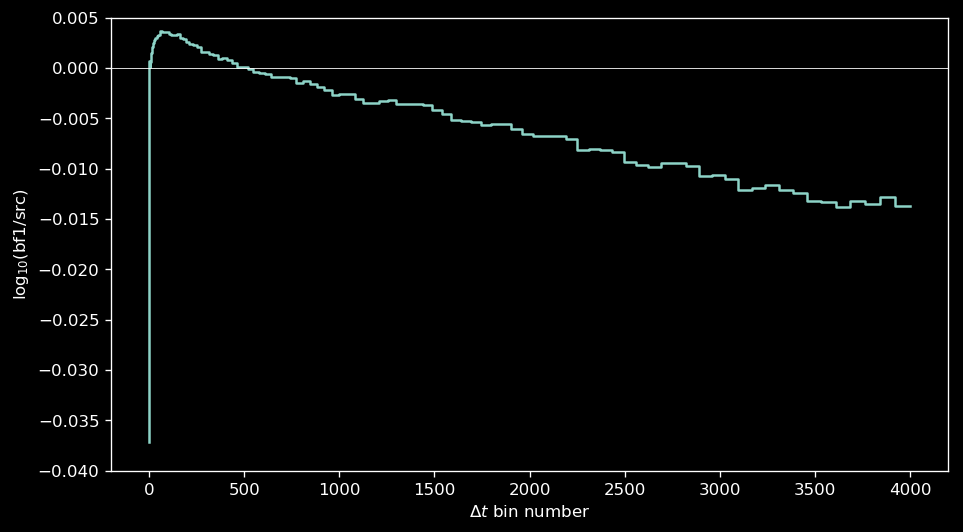

In [729]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
y = np.log10(bf1tbl_t*norm / srctbl_t)
ax.step(dt_be, [y[0]] + y.tolist())
xlim = ax.get_xlim()
ax.plot(xlim, [0]*2, 'w-', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(-.04, .005)
ax.set_ylabel(r'$\log_{10}({\rm bf1}/{\rm src})$')
ax.set_xlabel(r'$\Delta t$ bin number')
pass

In [491]:
%%time
ref_hist, ref_hist_be = np.histogram(reftbl, bins=int(1e5)+1, density=False)

CPU times: user 7.68 s, sys: 368 ms, total: 8.05 s
Wall time: 8.04 s


In [492]:
%%time
src_hist, src_hist_be = np.histogram(srctbl, bins=int(1e5)+1, density=False)

CPU times: user 8.5 s, sys: 1.35 s, total: 9.85 s
Wall time: 9.84 s


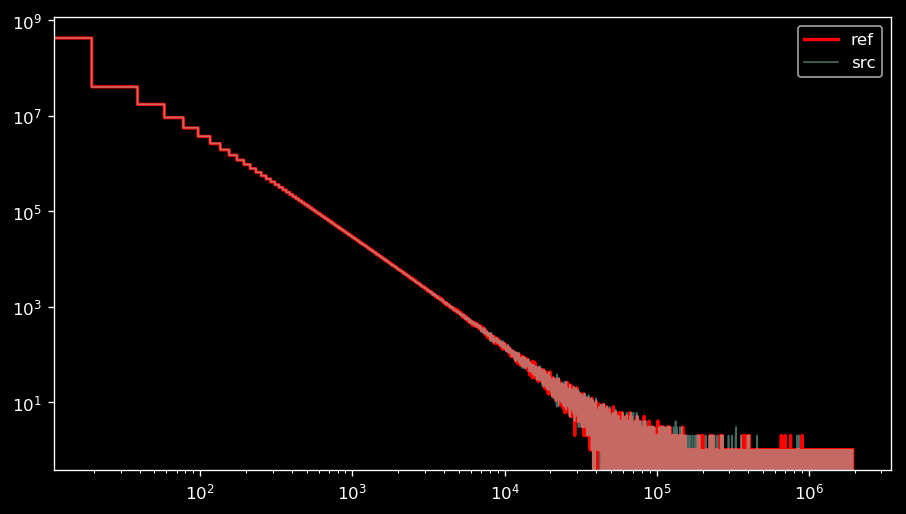

In [499]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.step(ref_hist_be, [ref_hist[0]] + ref_hist.tolist(), lw=2, c='r', label='ref')
ax.step(src_hist_be, [src_hist[0]] + src_hist.tolist(), lw=1, alpha=0.5, label='src')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')
pass

In [470]:
%%time

bin_edges = np.linspace(0, 2000, 10001)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

chi2_hists = OrderedDict()
num_members = len(members)
for member_i in range(num_members):
    t0 = time.time()
    string, dom = members[member_i].item()
    sys.stdout.write('member {:3d}/{:3d}: ({:2d}, {:2d})\n'.format(member_i, num_members, string, dom))
    sys.stdout.flush()
    fpath = join(
        ddir,
        'clsim_table_set_b8e6e072_string_{}_dom_{}_seed_0_n_10000.fits'.format(string, dom)
    )
    srctbl_all = load_clsim_table_minimal(fpath)
    srctbl = srctbl_all['table'][slice_all]

    #chi2 = (np.square(srctbl - reftbl) / (srctbl + reftbl))[mask]
    chi2 = np.square(srctbl[mask] - reftbl[mask]) / reftbl[mask]
    
    chi2_hist, _ = np.histogram(chi2, bins=bin_edges, density=False)
    chi2_hists[(int(string), int(dom))] = chi2_hist
    sys.stdout.write(' ... {:.1f} sec for DOM table'.format(time.time() - t0))

In [417]:
np.log10(srctbl.max())

6.2860346

In [418]:
np.log10(reftbl.max())

6.2873015

In [475]:
chi2fitdist

array([0.50559762, 0.44336215, 0.39652916, ..., 0.        , 0.        ,
       0.        ])

In [476]:
chi2_hist / num_nonzero

array([6.12539255e-01, 1.06834828e-01, 5.96959926e-02, ...,
       2.22172712e-09, 0.00000000e+00, 0.00000000e+00])

In [461]:
%%time

logfit = False

chi2_fits = OrderedDict()
for (string, dom), chi2_hist in chi2_hists.items():
    sd = (int(string), int(dom))
    mask = chi2_hist != 0
    chi2_hist_nz = chi2_hist[mask] / num_nonzero
    masked_bin_centers = bin_centers[mask]

    dx = np.diff(bin_edges)

    def resid(dof):
        if logfit:
            y = stats.chi2.cdf(masked_bin_centers, dof)
            mask = y != 0
            return np.sum(np.square(np.log(y[mask] / chi2_hist_nz[mask]))) / np.sum(mask)
        else:
            y = np.diff(stats.chi2.cdf(bin_edges, dof)) / dx
            return np.sum(np.square(y - chi2_hist/num_nonzero))

    result = optimize.minimize_scalar(resid, bounds=[0.001, 2.0], method='bounded')
    dof = result.x
    print(sd, dof)
    chi2fitdist = stats.chi2.cdf(bin_edges, dof)
    chi2fitdist = (chi2fitdist[1:] - chi2fitdist[:-1]) / dx
    chi2_fits[sd] = chi2fitdist

((1, 60), 1.8827940357594868)
((2, 60), 1.8871253663661116)
((3, 60), 1.8882702762172106)
((4, 60), 1.8879960613121018)
((5, 60), 1.8808786942421833)
((6, 60), 1.9488651795473817)
((7, 60), 1.8857756168871465)
((8, 60), 1.8806332216709063)
((9, 60), 1.890108132627097)
((10, 59), 1.999993879092489)
((10, 60), 1.8824680715549185)
((11, 60), 1.8766500836964228)
((12, 60), 1.979965919957076)
((14, 60), 1.882783890927707)
((15, 60), 1.9220088982542025)
((16, 60), 1.8824593190380432)
((17, 60), 1.8956424793036883)
((18, 60), 1.8839161120464671)
((19, 60), 1.9999936345607514)
((22, 60), 1.8818843157293952)
((23, 60), 1.8924197633602196)
((24, 60), 1.9156090474440175)
((25, 60), 1.9153033073246155)
((26, 60), 1.9075142032296815)
((27, 60), 1.999994754625394)
((31, 60), 1.8834593501496728)
((32, 60), 1.894213665902859)
((33, 60), 1.8980231881242267)
((35, 60), 1.8774702608007747)
((41, 60), 1.908026653287168)
((42, 60), 1.9135795690850834)
((43, 60), 1.8909222766143206)
((44, 60), 1.90104326481

In [420]:
norm = np.sum(chi2fitdist) / np.sum(chi2_hist)
norm

1.1108636723995491e-08

In [153]:
np.sum(chi2fitdist*dx)

1.0

In [424]:
np.diff([0, 6])

array([6])

In [429]:
num_nonzero

0.879102109375

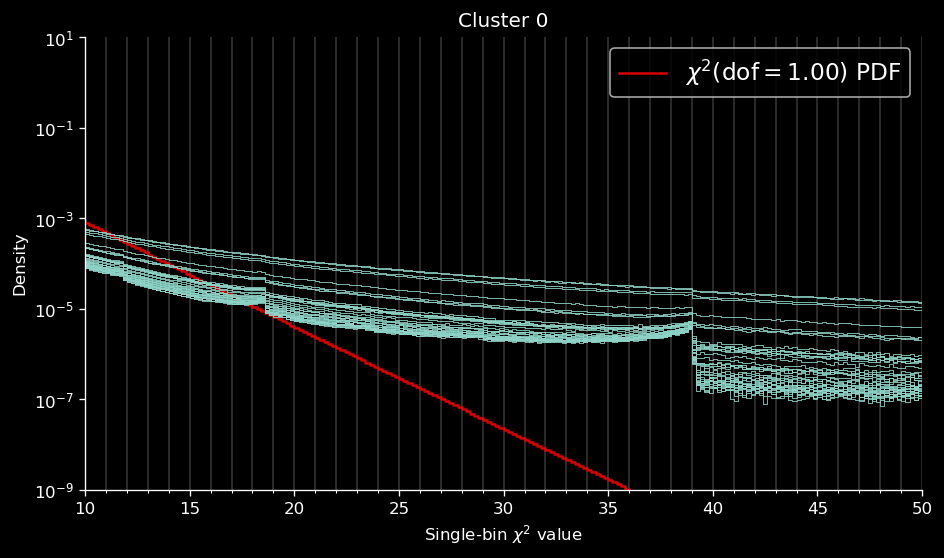

In [474]:
chi2_1dof_pdf = np.diff(stats.chi2.cdf(bin_edges, 1)) / np.diff(bin_edges)

fig, ax = plt.subplots(figsize=(9, 5), dpi=120)

ax.step(
    bin_edges,
    np.concatenate(([chi2_1dof_pdf[0]], chi2_1dof_pdf)),
    c='r', alpha=0.85,
    label=r'$\chi^2({\rm dof}={%.2f})$ PDF' % 1
)

for sd, chi2_hist in chi2_hists.items():
    chi2fitdist = chi2_fits[sd]
    ax.step(
        bin_edges,
        np.concatenate(([chi2_hist[0]], chi2_hist)) / num_nonzero,
        c='C0', lw=0.5,
        #label='{}, {}'.format(*sd)
    )
#     ax.step(
#         bin_edges,
#         np.concatenate(([chi2fitdist[0]], chi2fitdist)),
#         c='g', alpha=0.85,
#         label=r'$\chi^2({\rm dof}={%.2f})$ PDF' % dof
#     )
    
#ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks(np.arange(10, 51, 1), minor=True)
ax.grid(which='minor', b=True, linewidth=0.2)
ax.set_xlim(10, 50)
ax.set_ylim(1e-9, ax.get_ylim()[1])

ax.set_xlabel(r"Single-bin $\chi^2$ value")
ax.set_ylabel('Density')

removeBorder(ax)

ax.set_title('Cluster {}'.format(label))
ax.legend(loc='upper right', fontsize=14) #, title='String, OM')

#pltfbase = join(outdir, '')
#fig.savefig()
pass

In [407]:
bin_edges

array([0.00000000e+00, 1.17907982e+00, 2.35815964e+00, ...,
       1.17672166e+03, 1.17790074e+03, 1.17907982e+03])

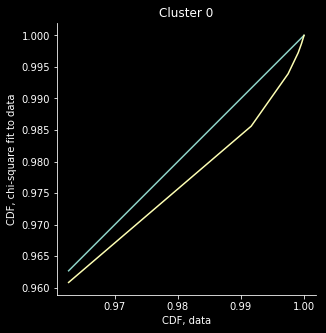

In [168]:
chi2cdf = np.cumsum(chi2_hist*dx)
chi2fitcdf = np.cumsum(chi2fitdist*dx)
cdfdiff = chi2fitcdf - chi2cdf

fig, ax = plt.subplots(figsize=(9, 5))
# ax.step(
#     bin_edges,
#     np.abs(np.concatenate(([cdfdiff[0]], cdfdiff))),
#     #label=r'$\chi^2({\rm dof}={%.2f})$ PDF' % dof
# )

ax.plot(chi2cdf, chi2cdf)
ax.plot(chi2cdf, chi2fitcdf)

# ax.step(
#     bin_edges,
#     np.concatenate(([chi2fitcdf[0]], chi2fitcdf)),
#     label=r'$\chi^2({\rm dof}={%.2f})$ PDF' % dof
# )
# ax.step(
#     bin_edges,
#     np.concatenate(([chi2cdf[0]], chi2cdf)),
#     label='{}, {}'.format(string, dom)
# )
#ax.set_yscale('log')
#ax.set_ylim(1e-9, 1e1)
#ax.set_xscale('log')
#ax.set_xlim(bin_centers[0], bin_edges[-1])
ax.set_xlabel(r"CDF, data")
ax.set_ylabel('CDF, chi-square fit to data')
ax.axis('image')
removeBorder(ax)
ax.set_title('Cluster {}'.format(label))
#ax.legend(loc='upper right', fontsize=14) #, title='String, OM')
#pltfbase = join(outdir, '')
#fig.savefig()
pass

In [373]:
%%time
ckvtbl = np.load('/data/icecube/retro_tables/tilt_on_anisotropy_on_noazimuth_80/cl0/ckv_table.npy')

CPU times: user 0 ns, sys: 1.33 s, total: 1.33 s
Wall time: 1.33 s


In [375]:
ckvtbl.shape

(80, 40, 100, 40, 40)

In [376]:
np.sum(ckvtbl == 0)

22752753

In [377]:
132517232 / ckvtbl.size

0.25882271875

In [186]:
np.sum(reftbl == 0) / reftbl.size

0.120897890625

In [378]:
np.all(ckvtbl[ix] == 0)

False

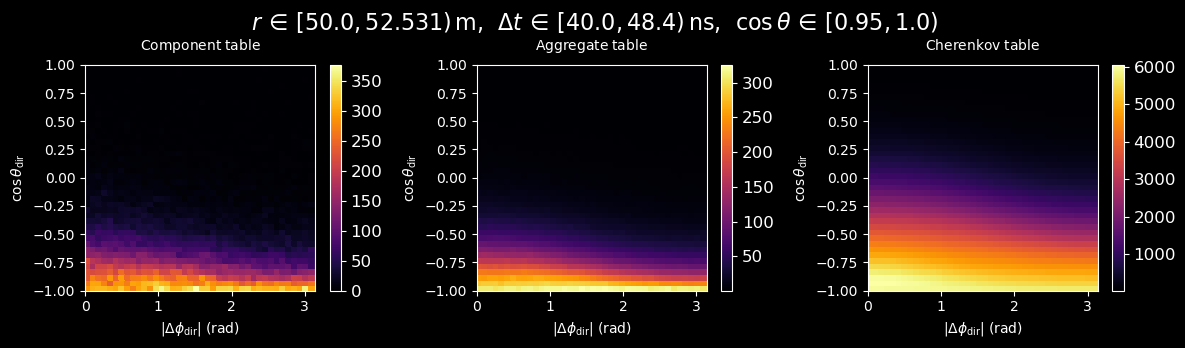

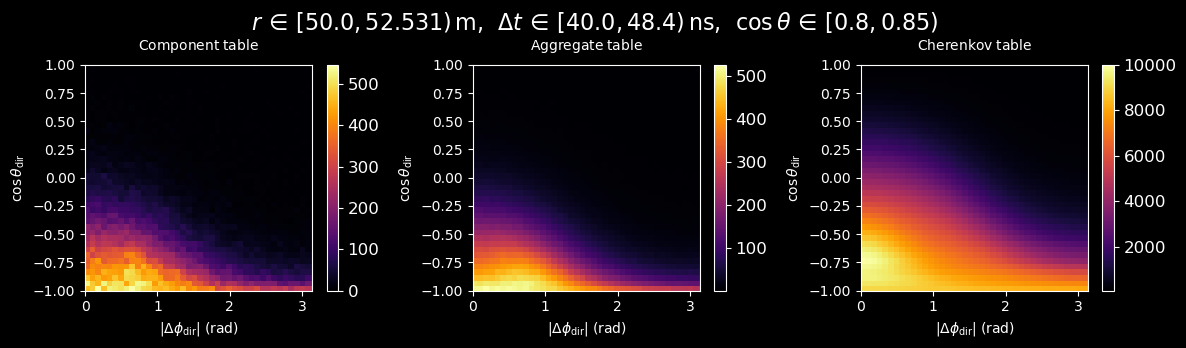

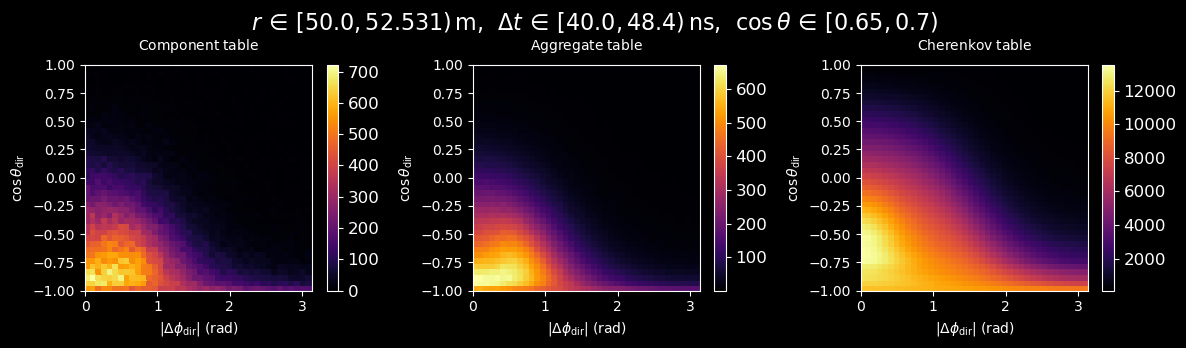

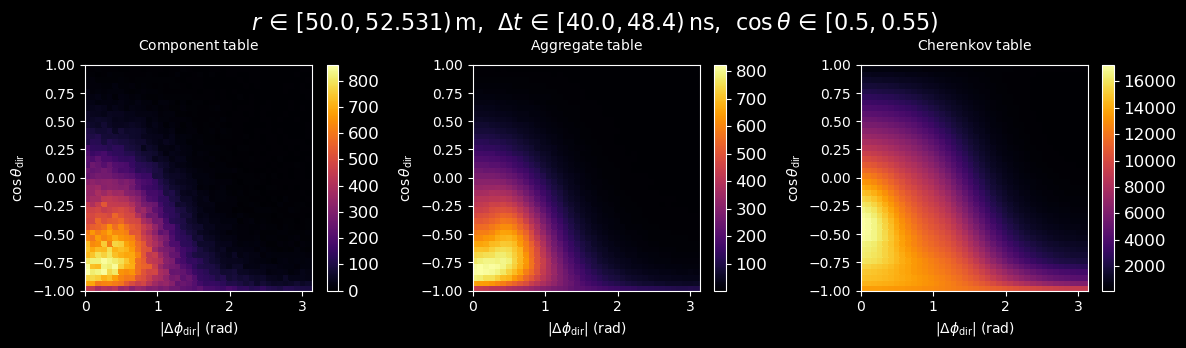

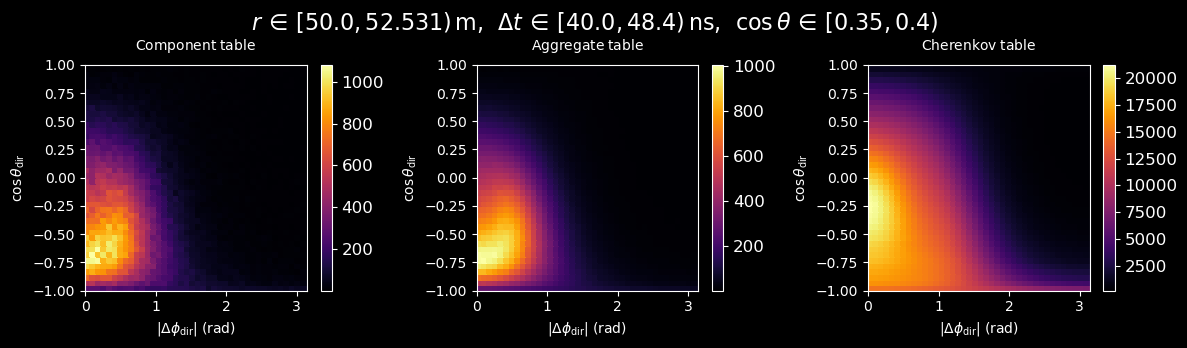

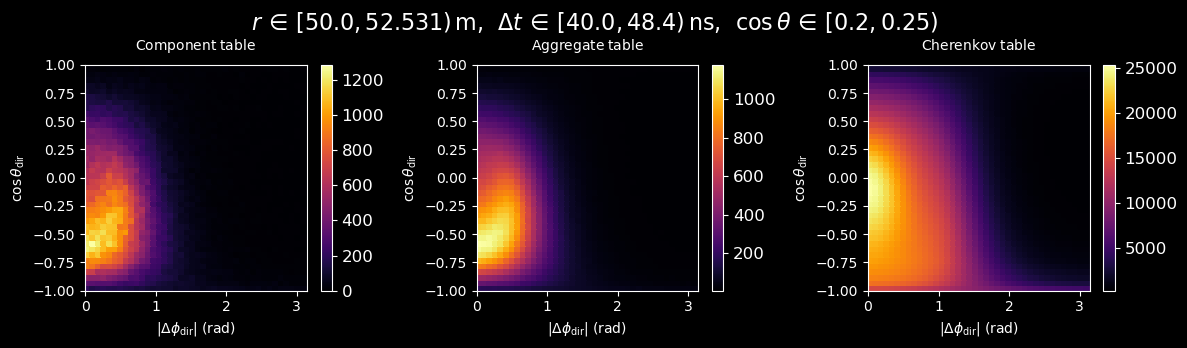

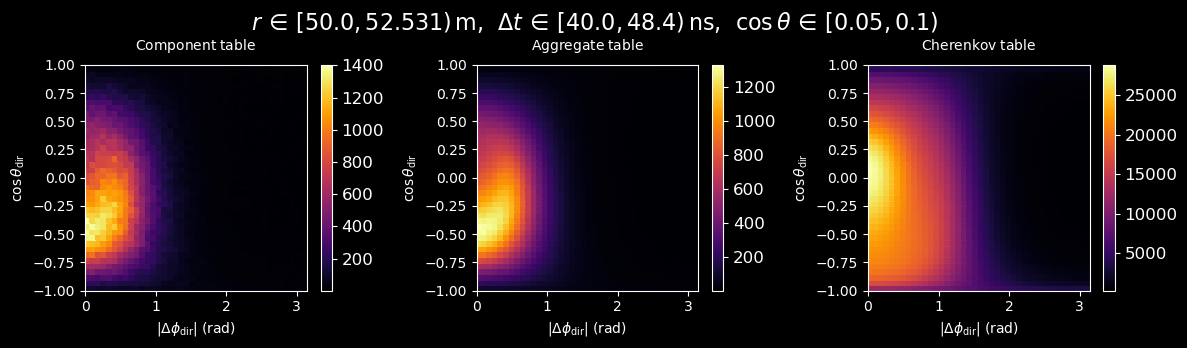

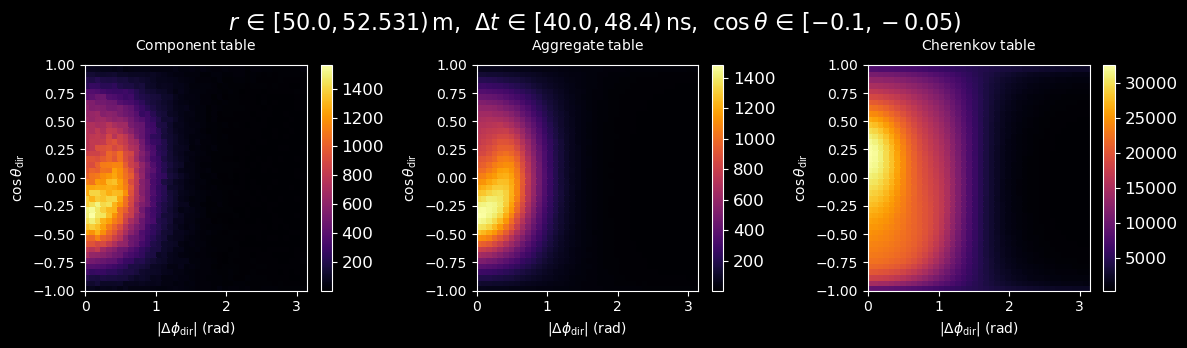

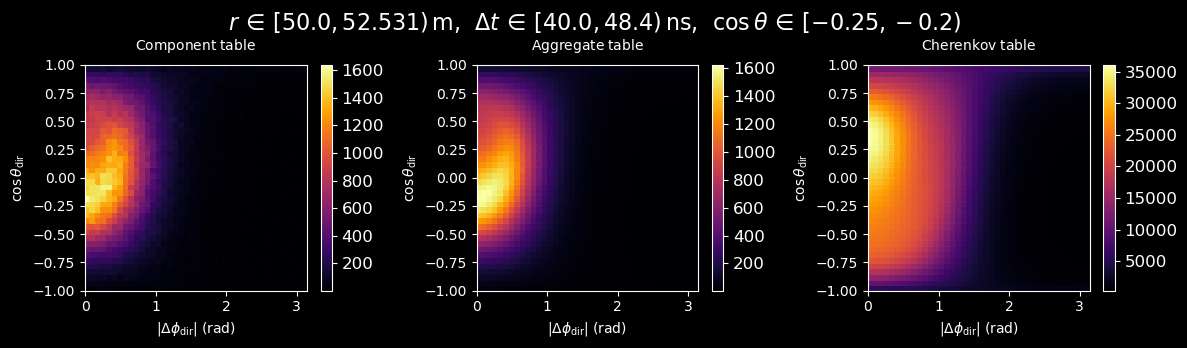

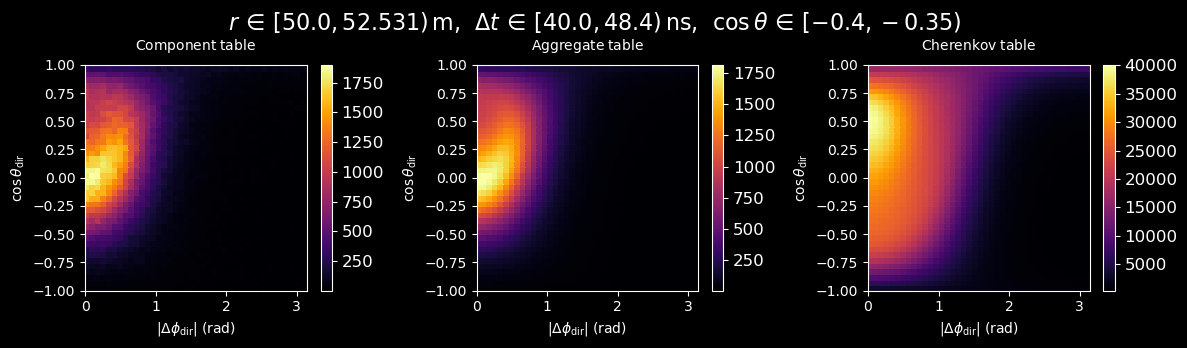

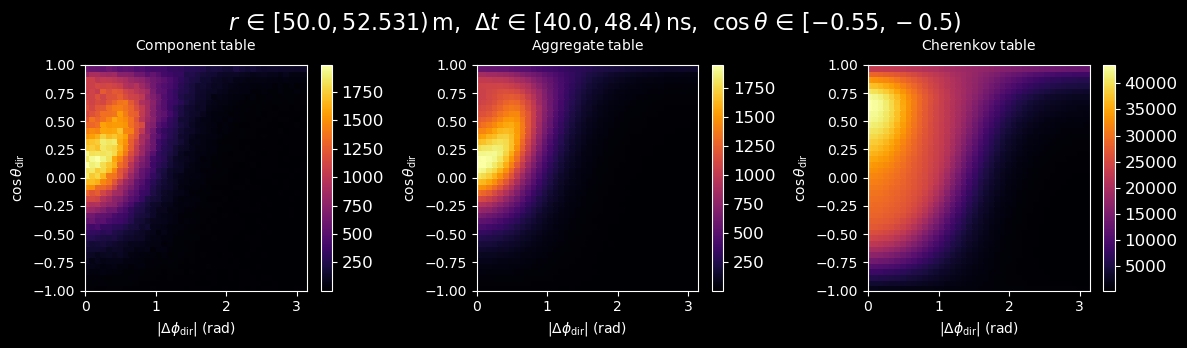

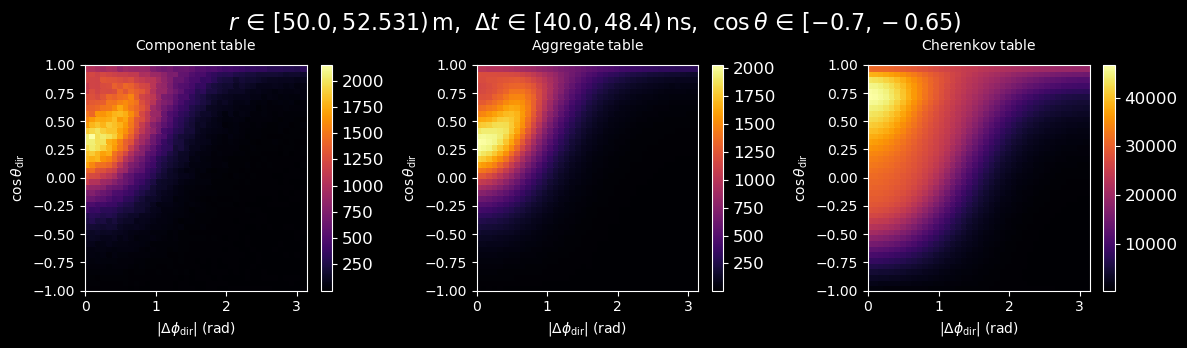

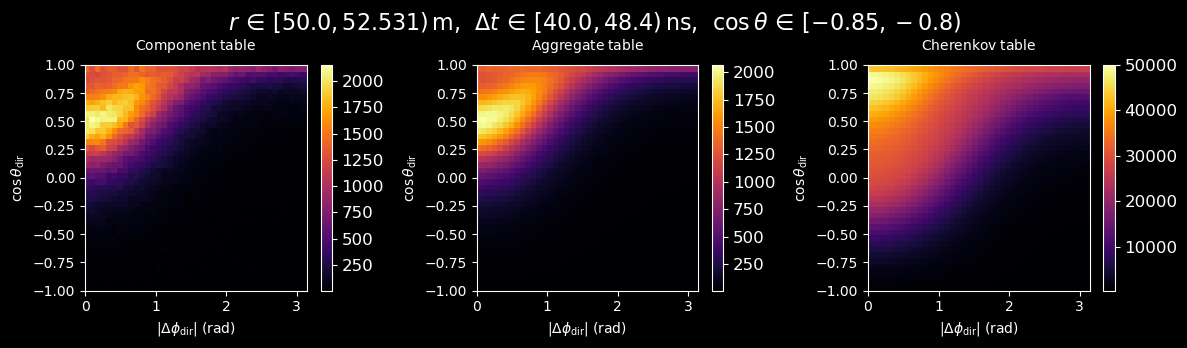

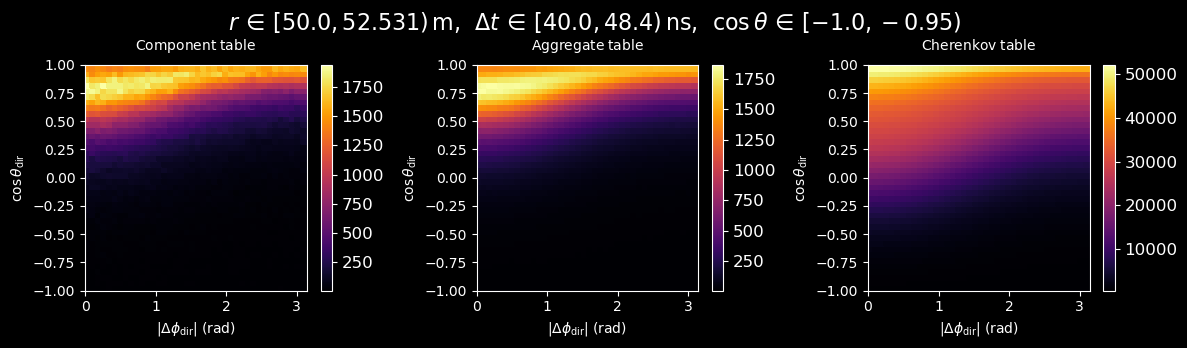

In [401]:
plt.close('all')
rbi, dtbi = 40, 10
for ctbi in range(39, -1, -3):
    ix = (rbi, ctbi, dtbi, slice(None), slice(None))
    ctb, rb, dtb = binning.ct[ctbi], binning.r[rbi], binning.dt[dtbi]
    b = binning[ix].squeeze().reorder_dimensions(('dpdir', 'ctdir'))
    m1 = Map(name='Component table', hist=srctbl[ix].T, binning=b)
    m2 = Map(name='Aggregate table', hist=reftbl[ix].T, binning=b)
    m3 = Map(name='Cherenkov table', hist=ckvtbl[ix].T, binning=b)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), dpi=100)
    m1.plot(ax=ax1)
    m2.plot(ax=ax2)
    m3.plot(ax=ax3)
    fig.suptitle(',  '.join([
        r'${} \, \in \, [{}, {}) \, {:~L}$'.format(rb.tex, np.round(rb.domain[0].m, 3), np.round(rb.domain[1].m, 3), rb.domain.u),
        r'${} \, \in \, [{}, {}) \, {:~L}$'.format(dtb.tex, dtb.domain[0].m, dtb.domain[1].m, dtb.domain.u),
        r'${} \, \in \, [{}, {})$'.format(ctb.tex, ctb.domain[0].m, ctb.domain[1].m),
        ]),
        fontsize=16
    )
    fig.tight_layout(rect=(0, 0, 1, 0.95))

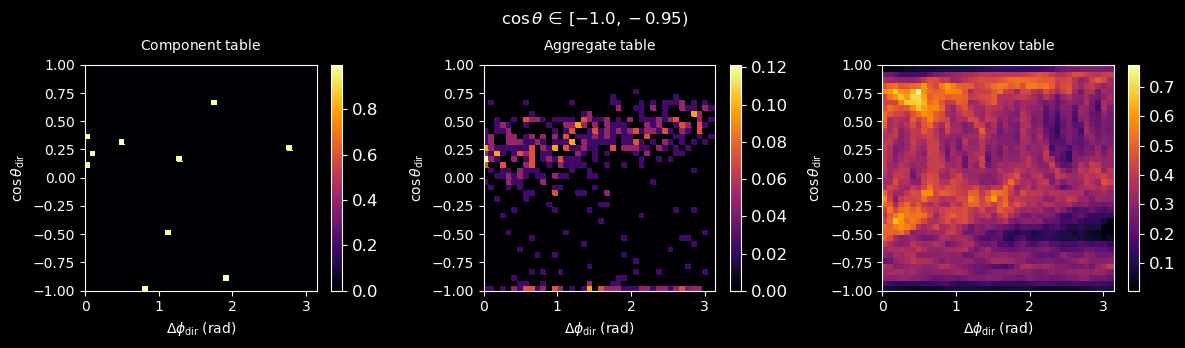

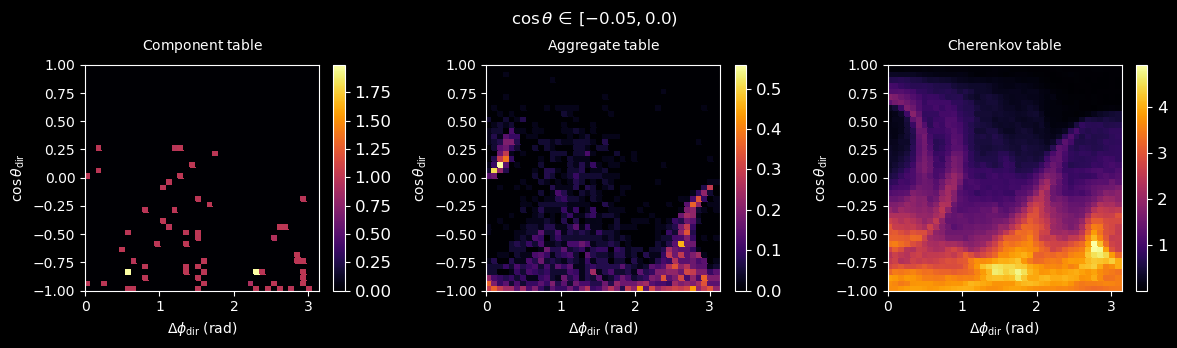

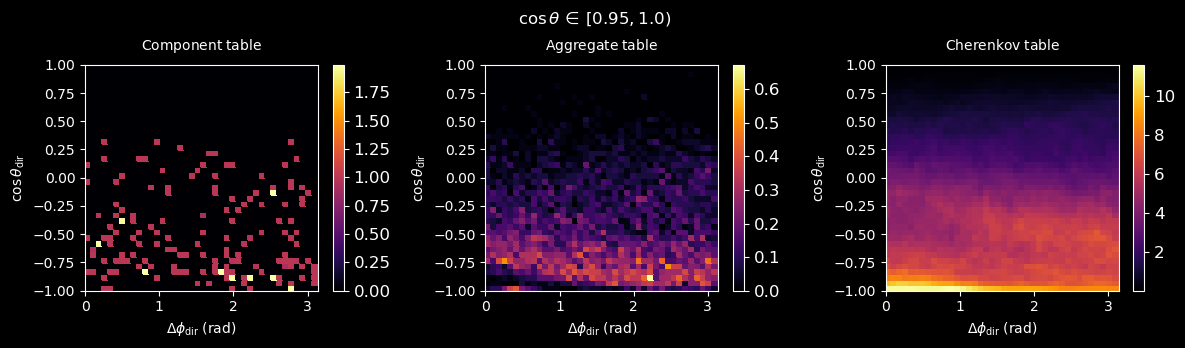

In [383]:
plt.close('all')
for cti in [0, 19, -1]:
    ix = (2, cti, 2, slice(None), slice(None))
    b = binning[ix].squeeze().reorder_dimensions(('dpdir', 'ctdir'))
    m1 = Map(name='Component table', hist=srctbl[ix].T, binning=b)
    m2 = Map(name='Aggregate table', hist=reftbl[ix].T, binning=b)
    m3 = Map(name='Cherenkov table', hist=ckvtbl[ix].T, binning=b)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), dpi=100)
    m1.plot(ax=ax1)
    m2.plot(ax=ax2)
    m3.plot(ax=ax3)
    ctb = binning.ct[cti]
    fig.suptitle(r'${} \, \in \, [{}, {})$'.format(ctb.tex, ctb.domain[0].m, ctb.domain[1].m))
    fig.tight_layout(rect=(0, 0, 1, 0.95))